In [1]:
%pylab inline
import numpy
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import scipy.misc
import seaborn as sns




def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

image_tensors = []
label_tensors = []

for i in range(1, 6):
    datadict = unpickle("/home/isaac/Downloads/cifar10/cifar-10-batches-py/data_batch_"+str(i))
    X = datadict["data"] 
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1)
    print X.dtype
    Y = np.array(Y)
    image_tensors.append(X)
    label_tensors.append(Y)
X_data_set = np.concatenate(image_tensors).astype(np.float32) / 127.5 - 1.0
Y_data_set = np.concatenate(label_tensors)



def show_cifar_image(image, title = ""):
    plt.figure(figsize=(1,1))
    image = ((image+1) * 127.5).astype(np.uint8)
    
    plt.imshow(image, interpolation='nearest')
    # note that using the "gray" option here does not acutally make the image grayscale.  
    # It's just a display parameter to prevent pyplot from using false colors.
    frame = plt.gca()

    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])

    plt.title(title)
    plt.show()
    


Populating the interactive namespace from numpy and matplotlib
uint8
uint8
uint8
uint8
uint8


255
0


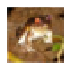

In [2]:
print np.max(X)
print np.min(X)

show_cifar_image(X_data_set[0])


In [13]:
%pylab inline
import tensorflow as tf
import tflearn
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
tf.reset_default_graph()

image_width = 32

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X_ph = tf.placeholder(tf.float32, shape=[None, image_width, image_width, 3])
Y_ph = tf.placeholder(tf.float32, shape=[None, 10])
image_is_real_ph = tf.placeholder(tf.float32, shape=[None])
z_dim = 100
Z_ph = tf.placeholder(tf.float32, shape=[None, z_dim])
discriminator_noise_sigma = tf.Variable(.2)

def sample_Z(m, n):
    return numpy.random.normal(loc=0.0, scale=1.0, size=[m, n])



def generator(z, y):

    m = z #tflearn.layers.merge([z, y], "concat")
    m = tflearn.layers.core.fully_connected(m, 32*8*8, activation='LeakyReLU')
    m = tf.reshape(m,[-1,8,8,32])
    m = tflearn.conv_2d_transpose(m, 32, 5, [image_width/4, image_width/4, 32], strides=1, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/4, image_width/4, 64], strides=1, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/4, image_width/4, 64], strides=1, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/4, image_width/4, 64], strides=1, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/4, image_width/4, 64], strides=1, activation='LeakyReLU')

    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/2, image_width/2, 64], strides=2, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 64, 5, [image_width/2, image_width/2, 64], strides=1, activation='LeakyReLU')

    m = tflearn.conv_2d_transpose(m, 32, 5, [image_width, image_width, 32], strides=2, activation='LeakyReLU')
    m = tflearn.conv_2d_transpose(m, 3, 5, [image_width, image_width, 3], strides=1, activation='tanh')
    print "generator output shape", m.get_shape()
    return m



def dc_discriminator(x, y):
    print "X into D shape", x.get_shape()

    gaussian_noise = \
        tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=discriminator_noise_sigma, dtype=tf.float32)
    
    x = x + gaussian_noise
        
    m = tflearn.layers.conv.conv_2d(x, 64, 5, activation = "LeakyReLU")
    m = tflearn.layers.conv.conv_2d(x, 64, 5, activation = "LeakyReLU")

    m = tflearn.layers.conv.avg_pool_2d(m, 2)
    m = tflearn.layers.conv.conv_2d(m, 64, 5, activation = "LeakyReLU")
    m = tflearn.layers.conv.conv_2d(m, 64, 5, activation = "LeakyReLU")
    m = tflearn.layers.conv.conv_2d(m, 64, 5, activation = "LeakyReLU")

    m = tflearn.layers.conv.avg_pool_2d(m, 2)
    m = tflearn.layers.conv.conv_2d(m, 64, 5, activation = "LeakyReLU")
    print "last D conv layer shape", m.get_shape()
    m = tflearn.layers.fully_connected(m, 100, activation='LeakyReLU')
#     m = tflearn.layers.merge([m, y], "concat")
    m = tflearn.layers.fully_connected(m, 400, activation='LeakyReLU')

    logit = tflearn.layers.fully_connected(m, 1, activation='linear')
    prob = tf.nn.sigmoid(logit)
    return prob, logit


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        show(sample)

    return fig

with tf.variable_scope("gen"):
    G_sample =generator(Z_ph, Y_ph)

with tf.variable_scope("adv"):
    D_real, D_logit_real = dc_discriminator(X_ph, Y_ph)
with tf.variable_scope("adv", reuse=True):
    D_fake, D_logit_fake = dc_discriminator(G_sample, Y_ph)


# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(D_logit_fake - D_logit_real)
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.ones_like(D_logit_fake)))




D_solver = tf.train.AdamOptimizer().minimize(D_loss,
                                    var_list =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='adv'))

G_solver = tf.train.AdamOptimizer().minimize(G_loss,
                                    var_list =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='gen'))

Z_dim = 100

mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

if not os.path.exists('../out/'):
    os.makedirs('../out/')

i = 0
D_loss_record = []
G_loss_record = []


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


generator output shape (?, 32, 32, 3)
X into D shape (?, 32, 32, 3)
last D conv layer shape (?, 8, 8, 64)
X into D shape (?, 32, 32, 3)
last D conv layer shape (?, 8, 8, 64)
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Iter: 0
D loss: 1.387
G_loss: 0.6773
()


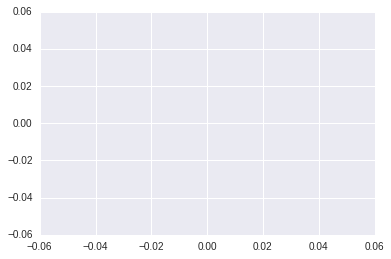

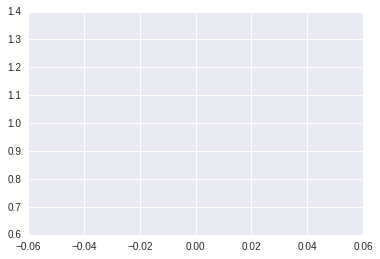

(128, 32, 32, 3)


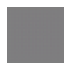

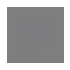

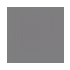

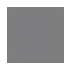

Iter: 1000
D loss: 4.684e-05
G_loss: 9.86
()


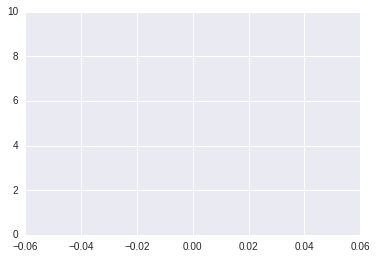

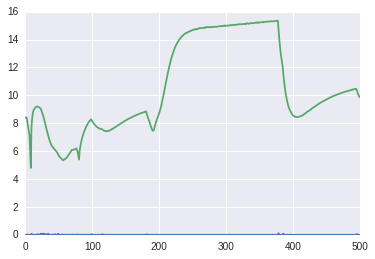

(128, 32, 32, 3)


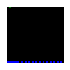

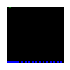

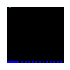

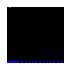

Iter: 2000
D loss: 0.3224
G_loss: 2.951
()


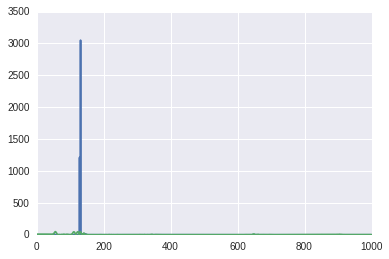

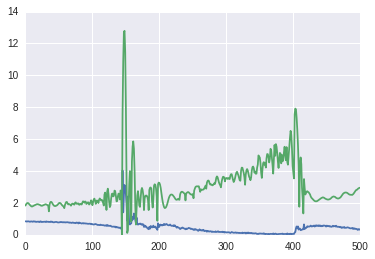

(128, 32, 32, 3)


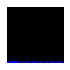

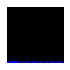

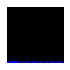

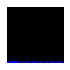

Iter: 3000
D loss: 0.0163
G_loss: 5.858
()


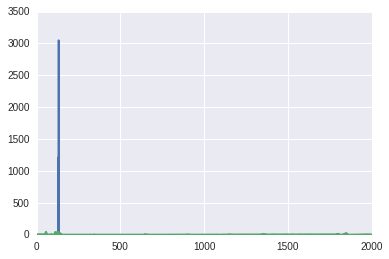

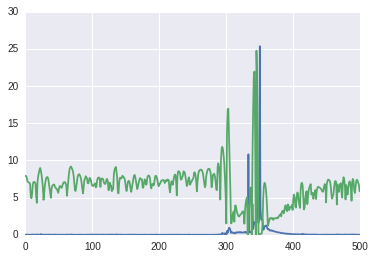

(128, 32, 32, 3)


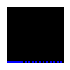

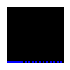

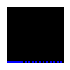

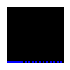

Iter: 4000
D loss: 0.000921
G_loss: 7.265
()


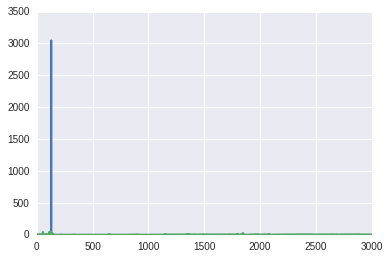

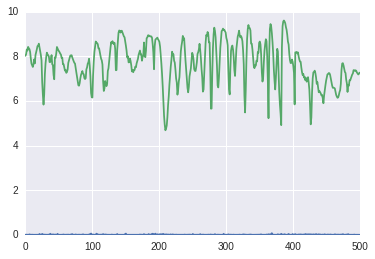

(128, 32, 32, 3)


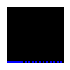

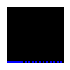

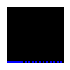

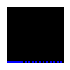

Iter: 5000
D loss: 0.0005513
G_loss: 8.975
()


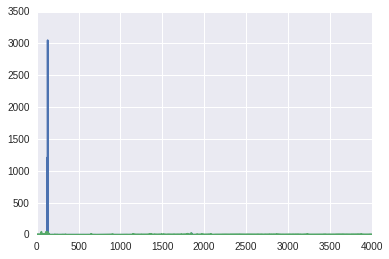

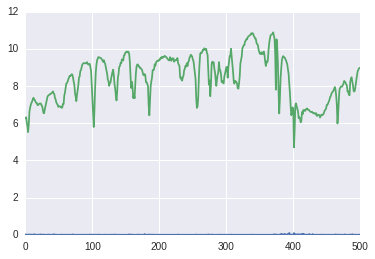

(128, 32, 32, 3)


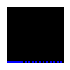

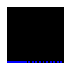

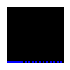

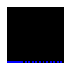

Iter: 6000
D loss: 1.301
G_loss: 12.3
()


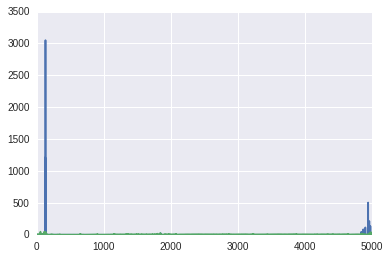

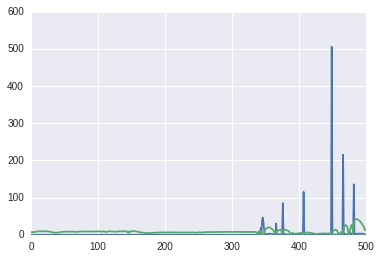

(128, 32, 32, 3)


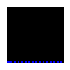

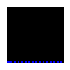

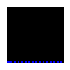

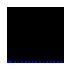

Iter: 7000
D loss: 0.00242
G_loss: 6.134
()


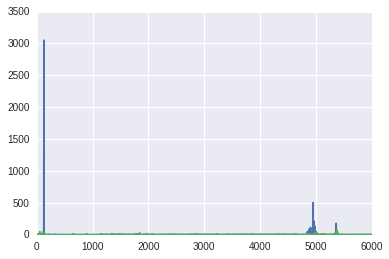

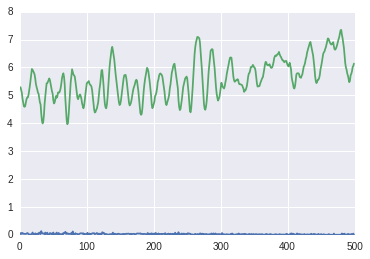

(128, 32, 32, 3)


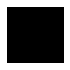

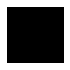

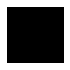

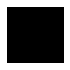

Iter: 8000
D loss: 0.002218
G_loss: 6.761
()


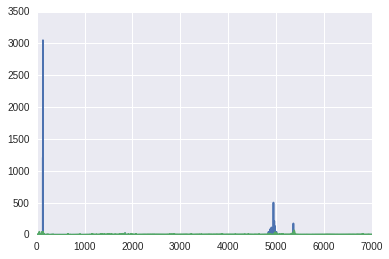

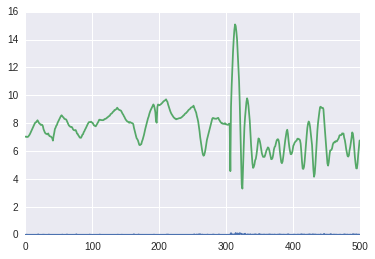

(128, 32, 32, 3)


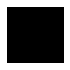

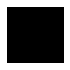

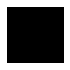

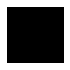

Iter: 9000
D loss: 0.0001399
G_loss: 9.569
()


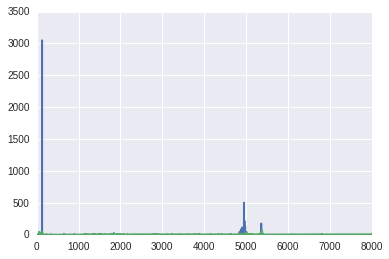

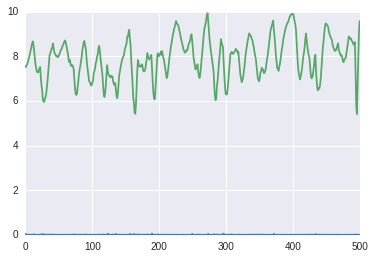

(128, 32, 32, 3)


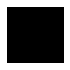

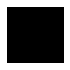

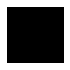

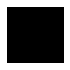

Iter: 10000
D loss: 3.722
G_loss: 2.656
()


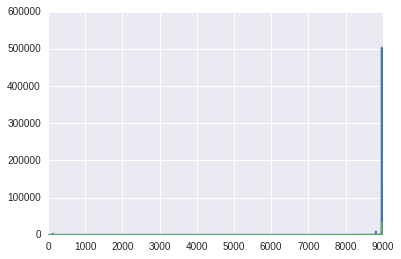

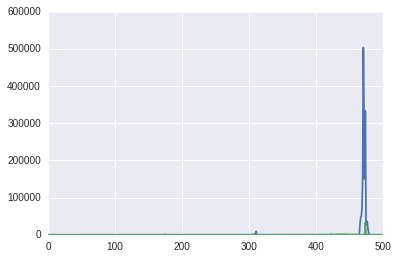

(128, 32, 32, 3)


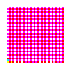

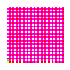

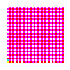

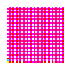

Iter: 11000
D loss: 0.5554
G_loss: 0.8535
()


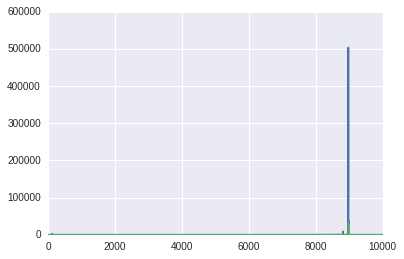

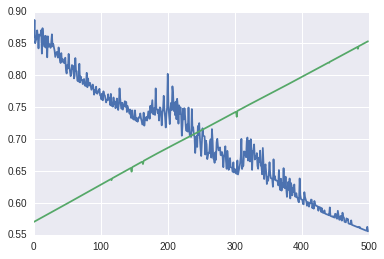

(128, 32, 32, 3)


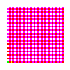

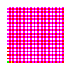

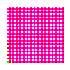

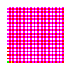

Iter: 12000
D loss: 1.402
G_loss: 1.121
()


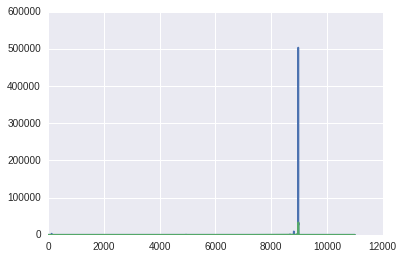

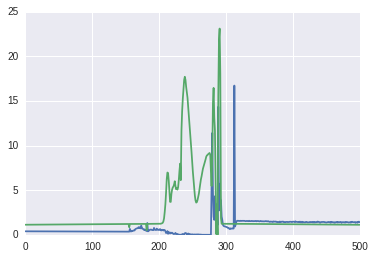

(128, 32, 32, 3)


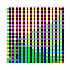

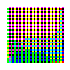

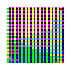

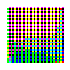

Iter: 13000
D loss: 0.3674
G_loss: 1.459
()


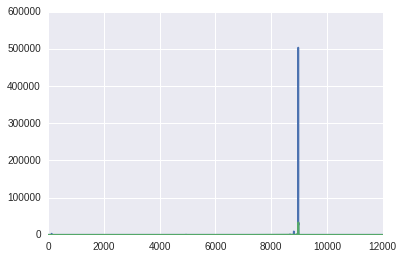

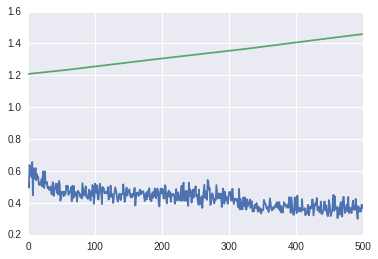

(128, 32, 32, 3)


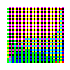

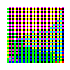

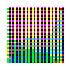

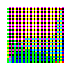

Iter: 14000
D loss: 0.5068
G_loss: 1.709
()


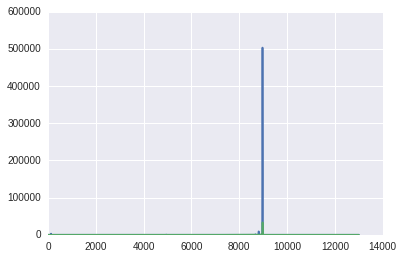

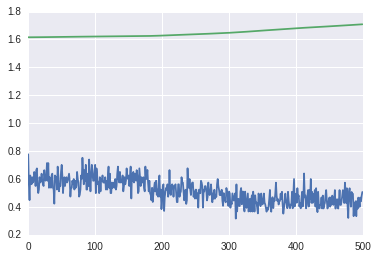

(128, 32, 32, 3)


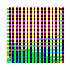

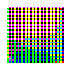

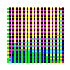

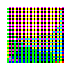

Iter: 15000
D loss: 0.5267
G_loss: 1.583
()


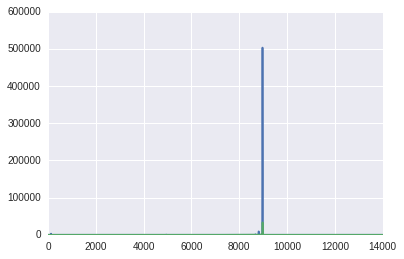

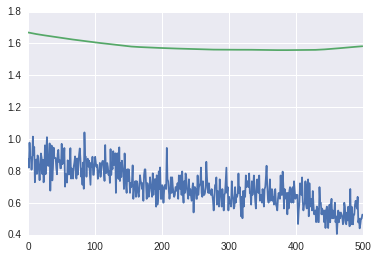

(128, 32, 32, 3)


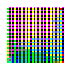

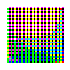

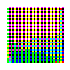

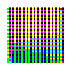

Iter: 16000
D loss: 0.2534
G_loss: 1.883
()


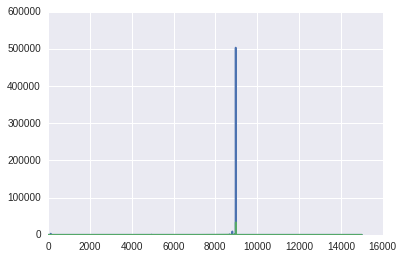

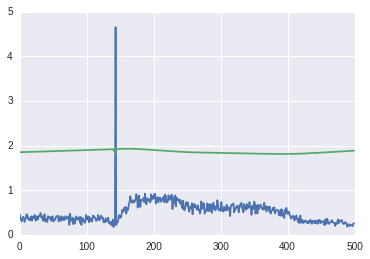

(128, 32, 32, 3)


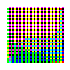

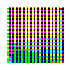

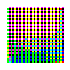

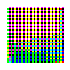

Iter: 17000
D loss: 0.2338
G_loss: 2.051
()


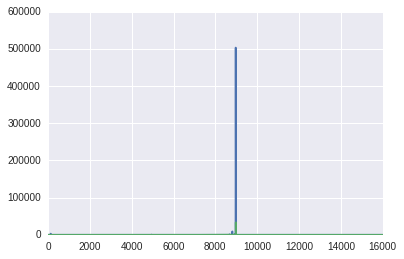

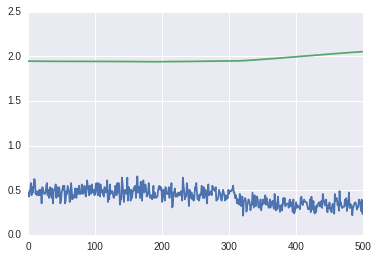

(128, 32, 32, 3)


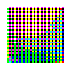

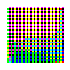

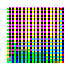

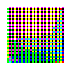

Iter: 18000
D loss: 0.1583
G_loss: 2.603
()


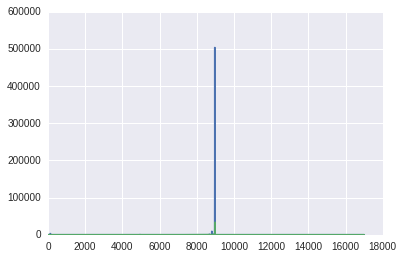

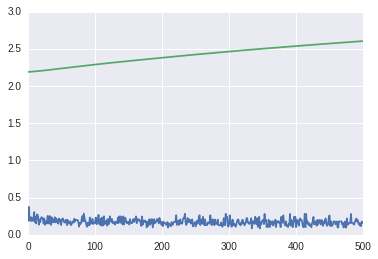

(128, 32, 32, 3)


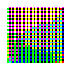

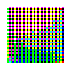

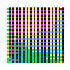

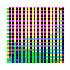

Iter: 19000
D loss: 0.1531
G_loss: 2.722
()


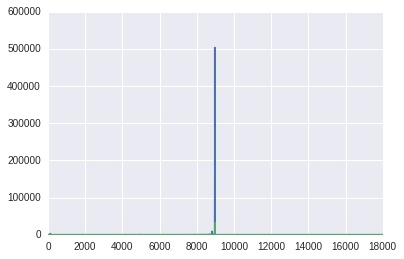

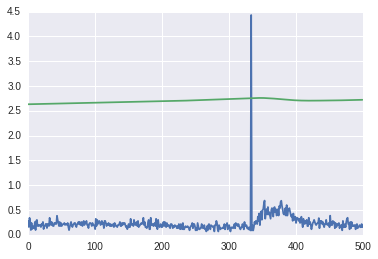

(128, 32, 32, 3)


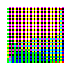

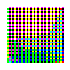

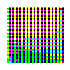

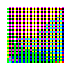

Iter: 20000
D loss: 1.131
G_loss: 2.72
()


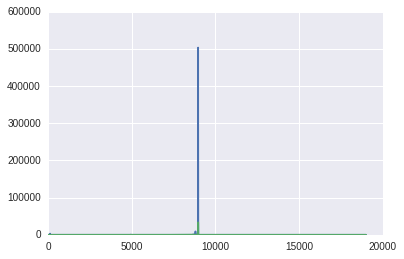

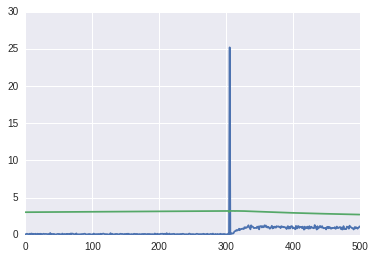

(128, 32, 32, 3)


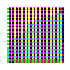

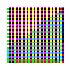

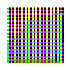

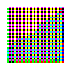

Iter: 21000
D loss: 0.2289
G_loss: 2.347
()


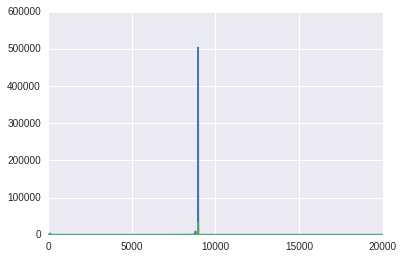

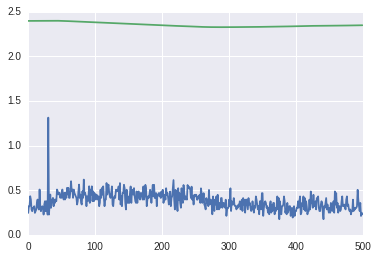

(128, 32, 32, 3)


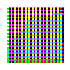

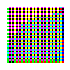

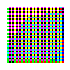

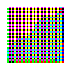

Iter: 22000
D loss: 0.1712
G_loss: 2.84
()


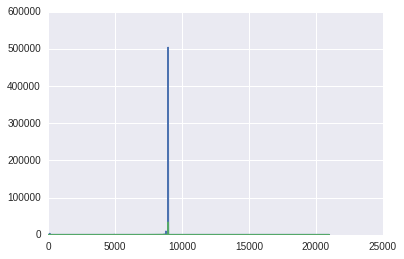

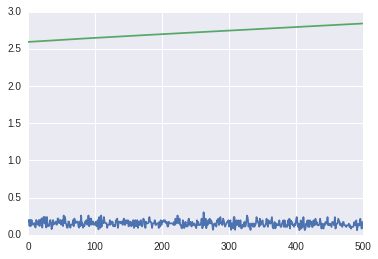

(128, 32, 32, 3)


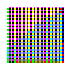

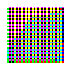

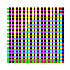

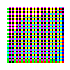

Iter: 23000
D loss: 0.1407
G_loss: 3.305
()


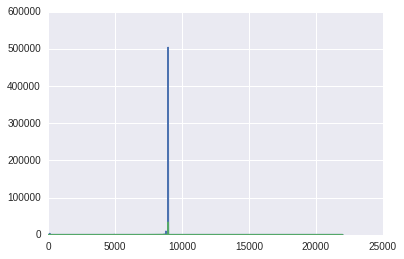

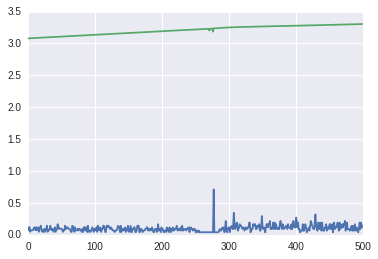

(128, 32, 32, 3)


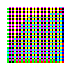

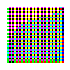

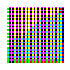

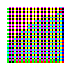

Iter: 24000
D loss: 0.0363
G_loss: 3.335
()


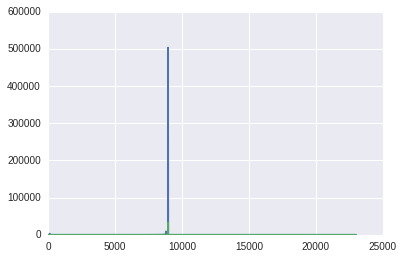

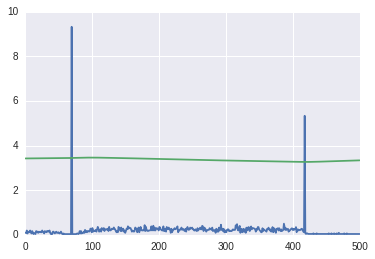

(128, 32, 32, 3)


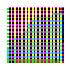

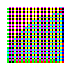

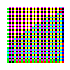

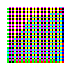

Iter: 25000
D loss: 0.01752
G_loss: 4.054
()


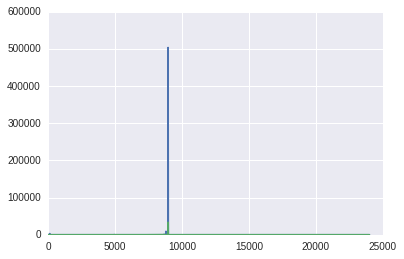

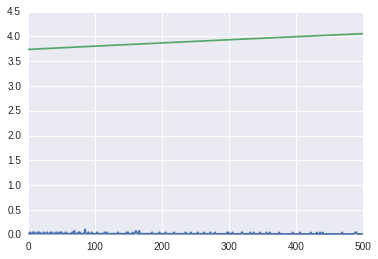

(128, 32, 32, 3)


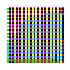

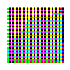

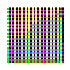

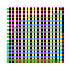

Iter: 26000
D loss: 0.01044
G_loss: 4.568
()


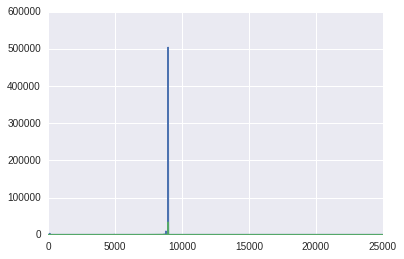

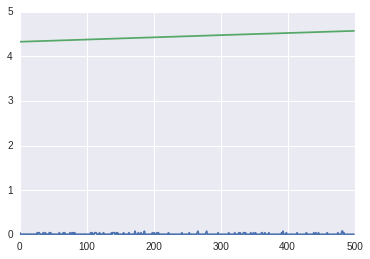

(128, 32, 32, 3)


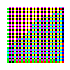

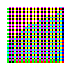

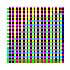

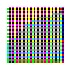

Iter: 27000
D loss: 0.006697
G_loss: 5.01
()


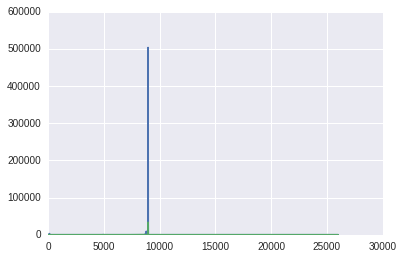

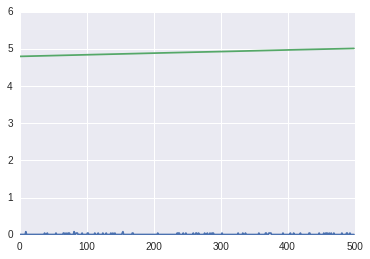

(128, 32, 32, 3)


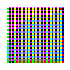

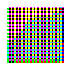

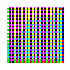

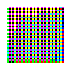

Iter: 28000
D loss: 0.004558
G_loss: 5.393
()


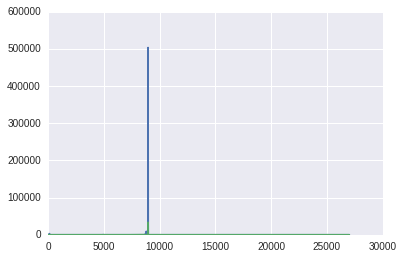

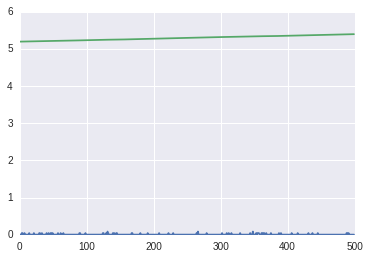

(128, 32, 32, 3)


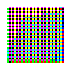

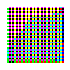

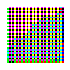

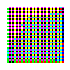

Iter: 29000
D loss: 0.0002222
G_loss: 8.856
()


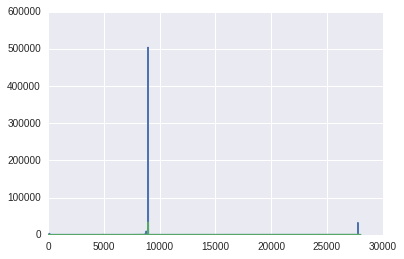

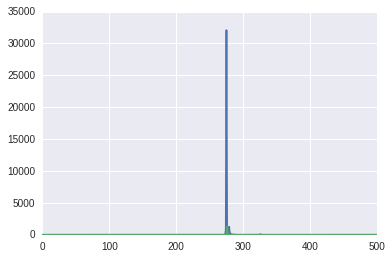

(128, 32, 32, 3)


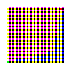

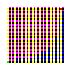

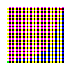

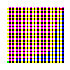

Iter: 30000
D loss: 8.59e-06
G_loss: 11.68
()


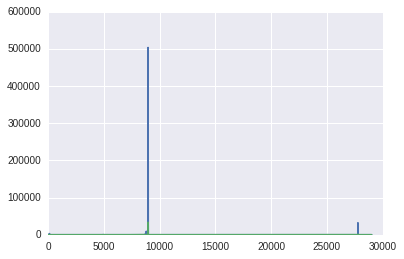

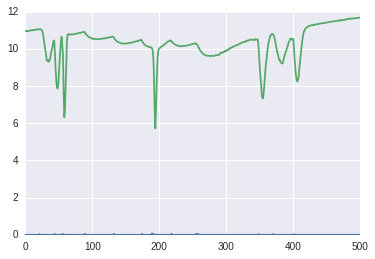

(128, 32, 32, 3)


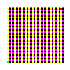

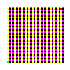

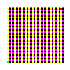

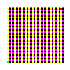

Iter: 31000
D loss: 9.015e-05
G_loss: 9.512
()


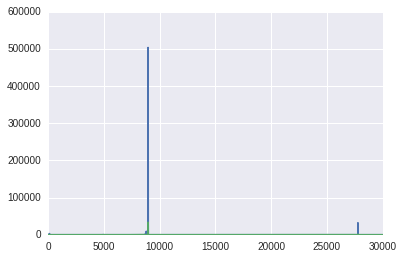

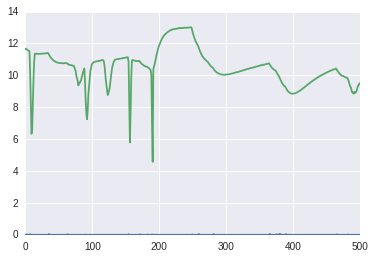

(128, 32, 32, 3)


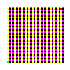

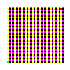

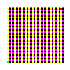

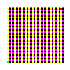

Iter: 32000
D loss: 2.179e-06
G_loss: 13.03
()


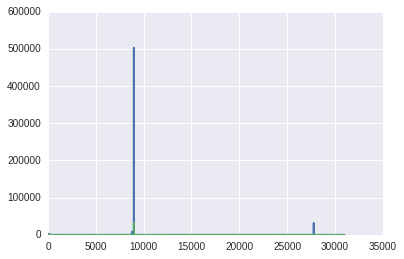

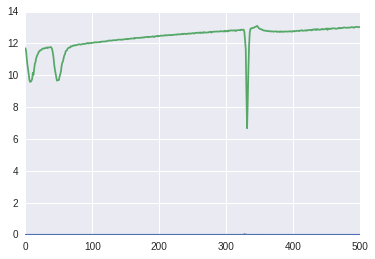

(128, 32, 32, 3)


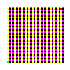

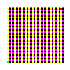

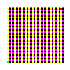

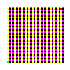

Iter: 33000
D loss: 2.179e-06
G_loss: 13.05
()


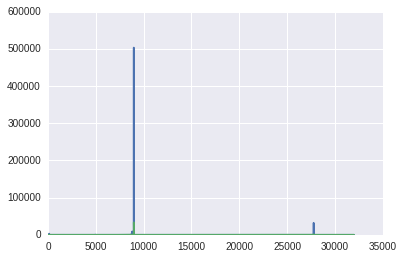

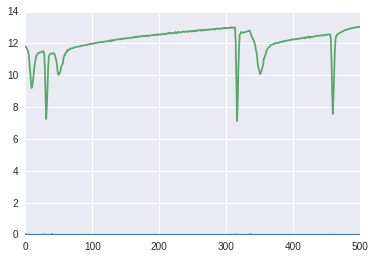

(128, 32, 32, 3)


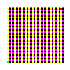

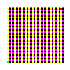

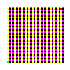

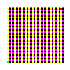

Iter: 34000
D loss: 0.0
G_loss: 117.5
()


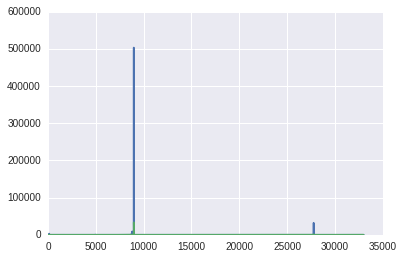

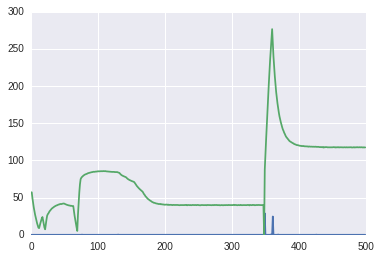

(128, 32, 32, 3)


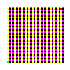

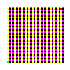

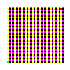

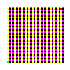

Iter: 35000
D loss: 7.048e-21
G_loss: 47.05
()


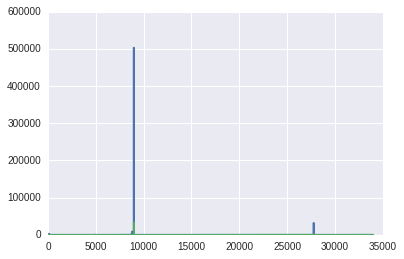

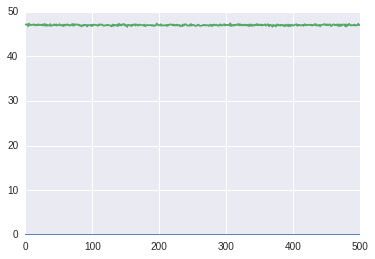

(128, 32, 32, 3)


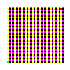

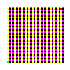

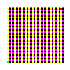

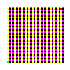

Iter: 36000
D loss: 2.646e-26
G_loss: 59.02
()


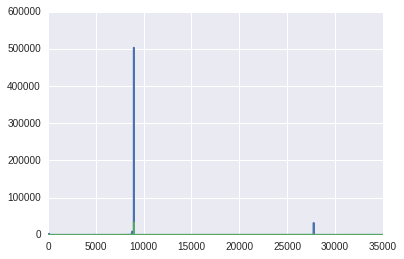

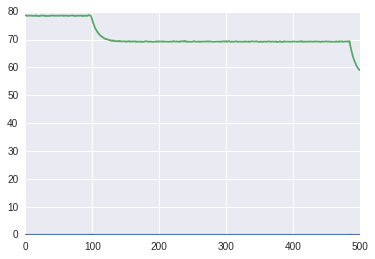

(128, 32, 32, 3)


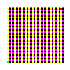

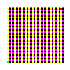

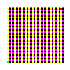

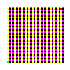

Iter: 37000
D loss: 3.157e-07
G_loss: 15.5
()


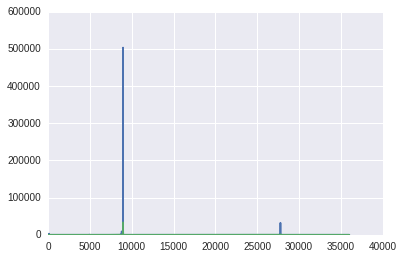

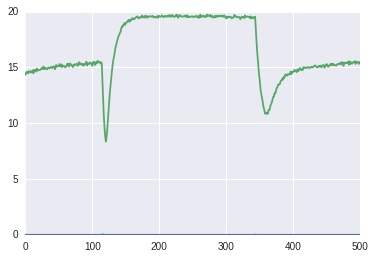

(128, 32, 32, 3)


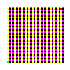

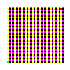

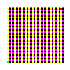

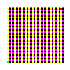

Iter: 38000
D loss: 1.086e-15
G_loss: 34.86
()


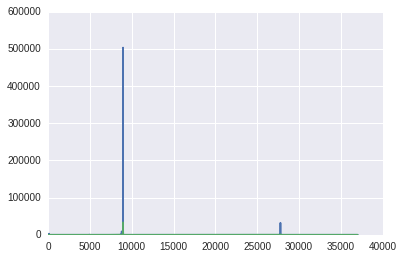

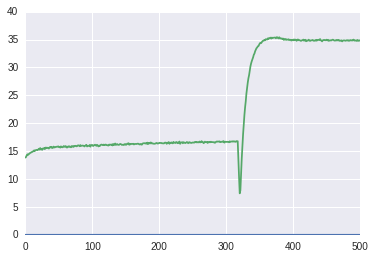

(128, 32, 32, 3)


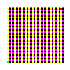

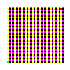

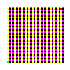

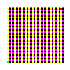

Iter: 39000
D loss: 2.711e-11
G_loss: 25.19
()


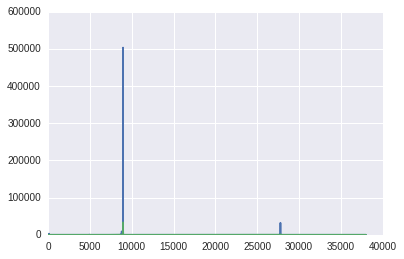

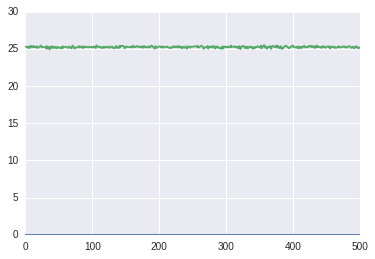

(128, 32, 32, 3)


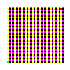

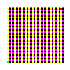

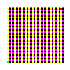

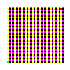

Iter: 40000
D loss: 2.177e-11
G_loss: 25.33
()


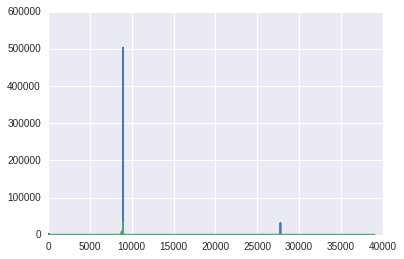

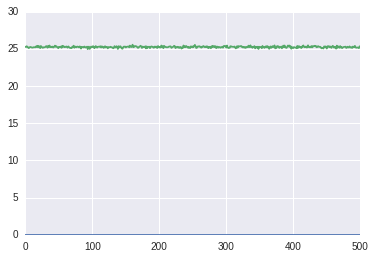

(128, 32, 32, 3)


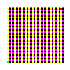

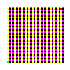

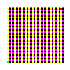

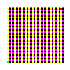

Iter: 41000
D loss: 3.054e-11
G_loss: 25.24
()


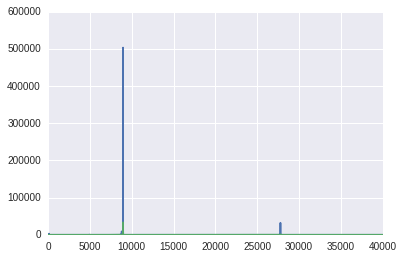

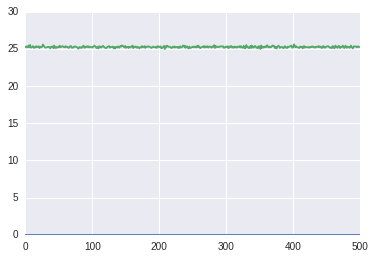

(128, 32, 32, 3)


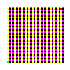

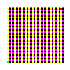

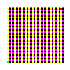

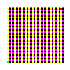

Iter: 42000
D loss: 1.731e-11
G_loss: 25.27
()


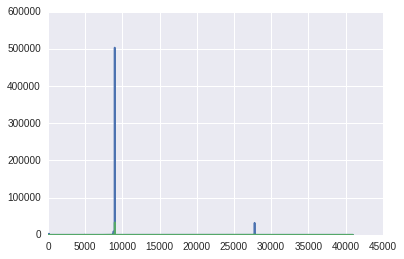

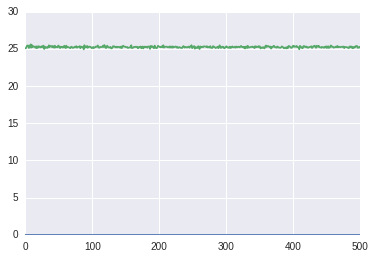

(128, 32, 32, 3)


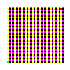

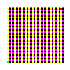

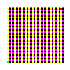

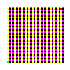

Iter: 43000
D loss: 2.463e-11
G_loss: 25.32
()


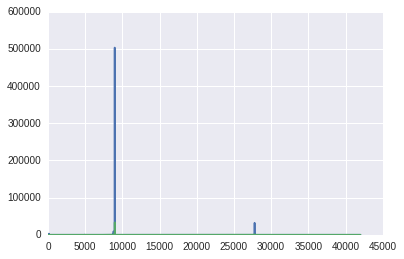

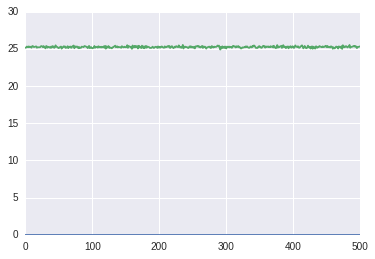

(128, 32, 32, 3)


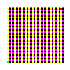

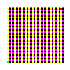

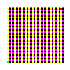

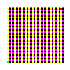

Iter: 44000
D loss: 2.567e-11
G_loss: 25.33
()


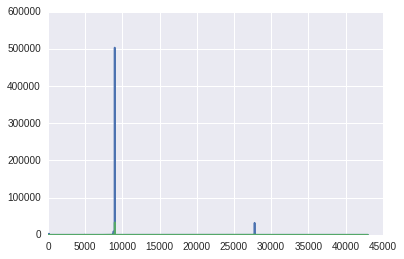

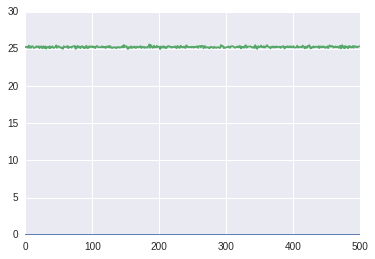

(128, 32, 32, 3)


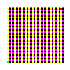

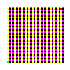

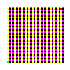

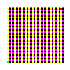

Iter: 45000
D loss: 3.211e-11
G_loss: 25.27
()


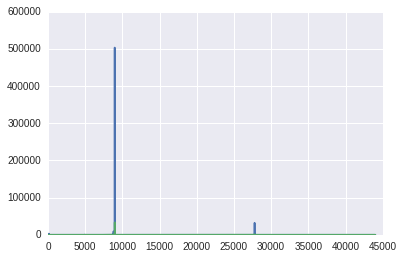

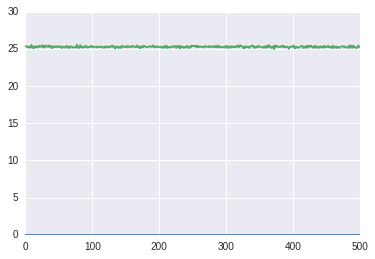

(128, 32, 32, 3)


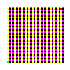

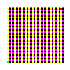

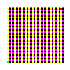

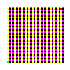

Iter: 46000
D loss: 2.549e-11
G_loss: 25.14
()


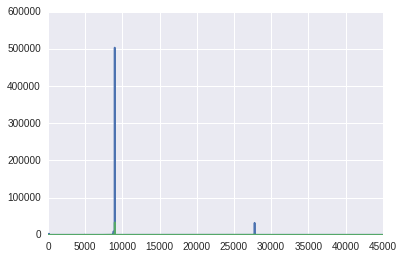

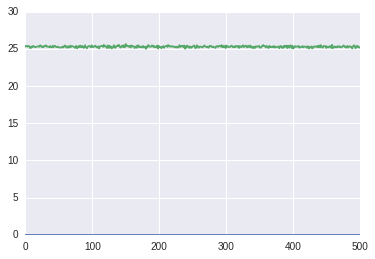

(128, 32, 32, 3)


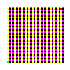

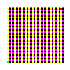

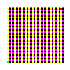

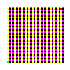

Iter: 47000
D loss: 1.869e-11
G_loss: 25.27
()


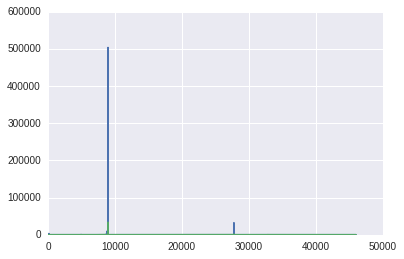

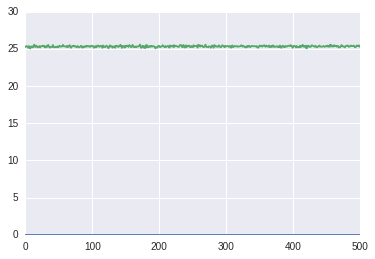

(128, 32, 32, 3)


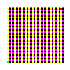

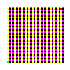

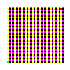

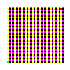

Iter: 48000
D loss: 1.637e-11
G_loss: 25.35
()


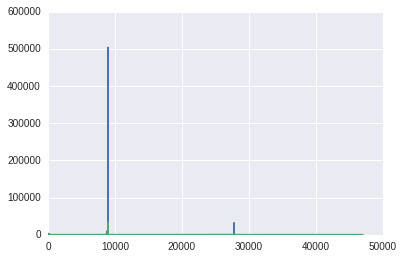

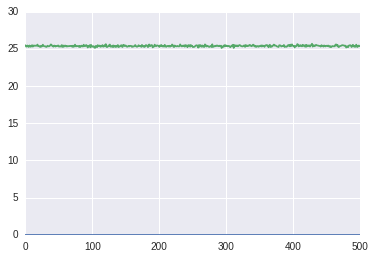

(128, 32, 32, 3)


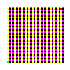

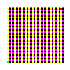

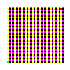

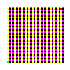

Iter: 49000
D loss: 1.399e-11
G_loss: 25.46
()


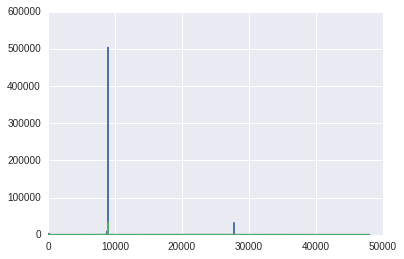

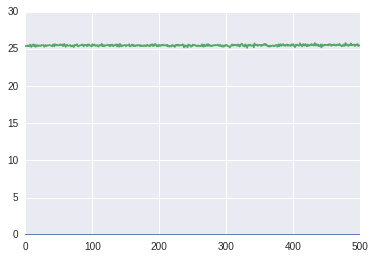

(128, 32, 32, 3)


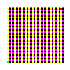

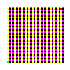

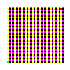

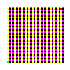

Iter: 50000
D loss: 9.353e-12
G_loss: 25.72
()


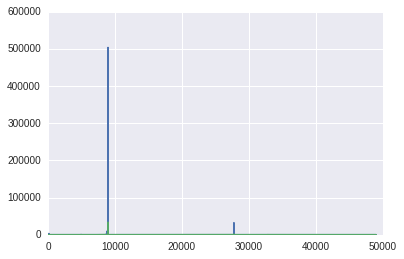

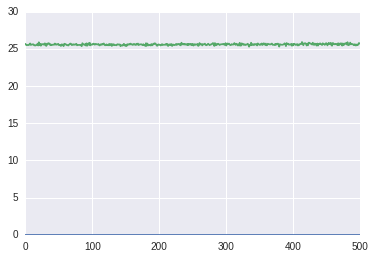

(128, 32, 32, 3)


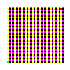

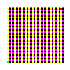

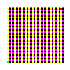

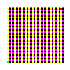

Iter: 51000
D loss: 1.03e-11
G_loss: 25.78
()


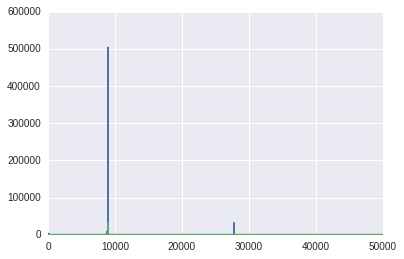

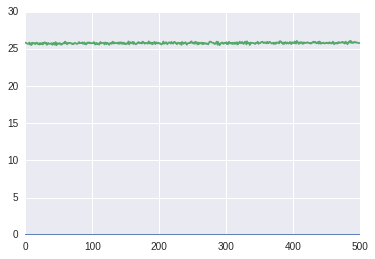

(128, 32, 32, 3)


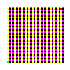

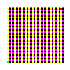

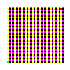

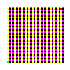

Iter: 52000
D loss: 9.362e-12
G_loss: 26.14
()


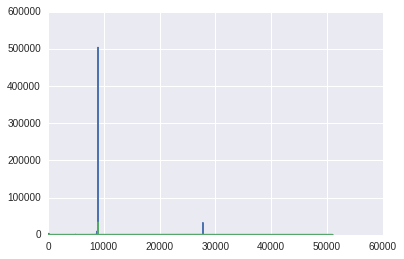

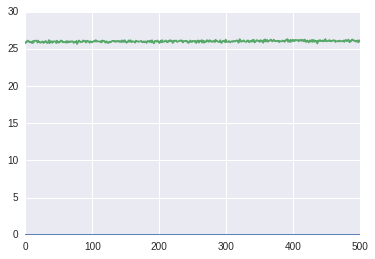

(128, 32, 32, 3)


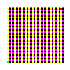

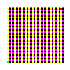

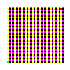

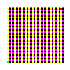

Iter: 53000
D loss: 6.605e-12
G_loss: 26.45
()


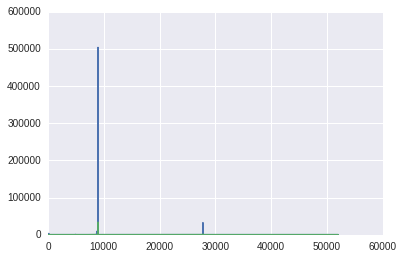

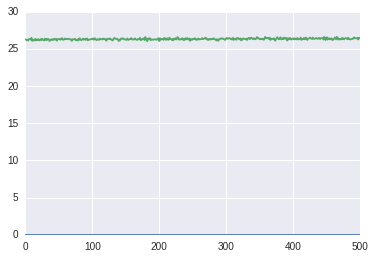

(128, 32, 32, 3)


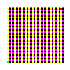

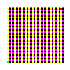

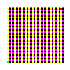

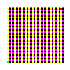

Iter: 54000
D loss: 3.729e-12
G_loss: 26.78
()


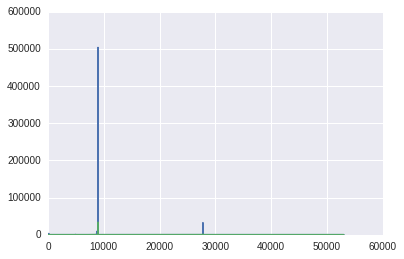

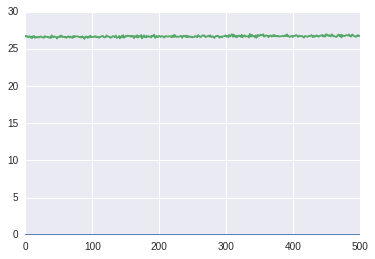

(128, 32, 32, 3)


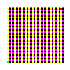

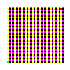

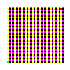

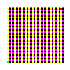

Iter: 55000
D loss: 2.545e-12
G_loss: 27.06
()


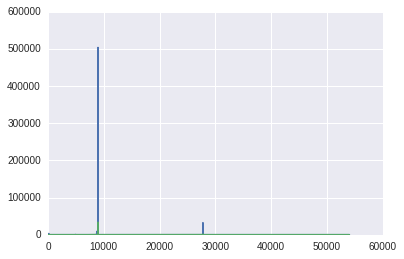

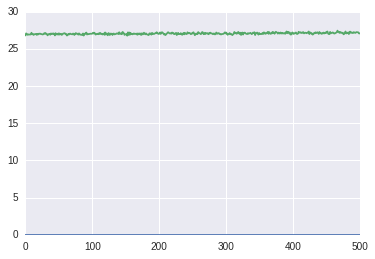

(128, 32, 32, 3)


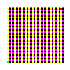

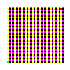

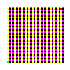

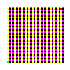

Iter: 56000
D loss: 1.67e-12
G_loss: 27.45
()


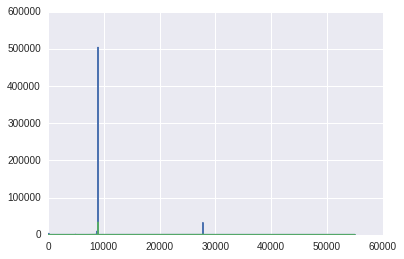

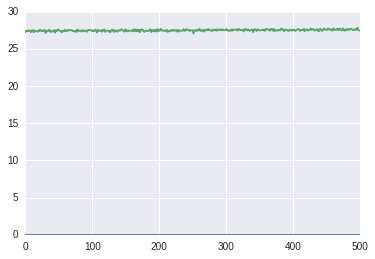

(128, 32, 32, 3)


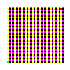

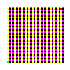

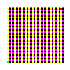

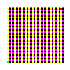

Iter: 57000
D loss: 1.003e-12
G_loss: 28.16
()


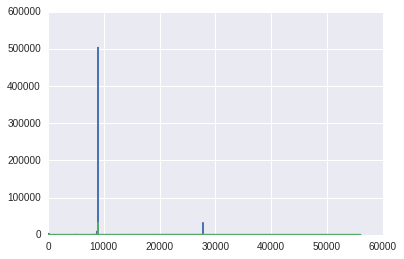

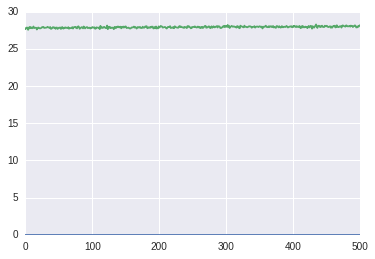

(128, 32, 32, 3)


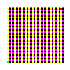

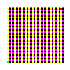

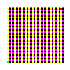

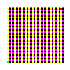

Iter: 58000
D loss: 9.661e-13
G_loss: 28.37
()


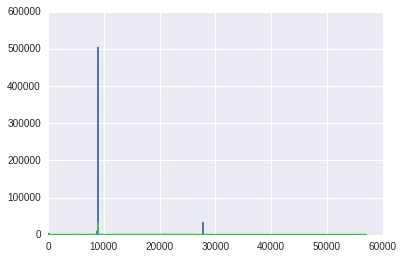

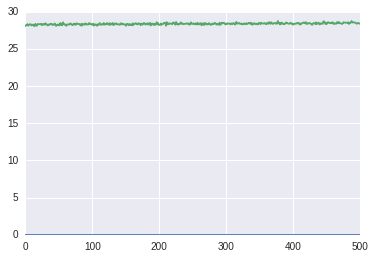

(128, 32, 32, 3)


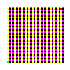

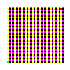

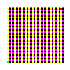

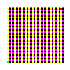

Iter: 59000
D loss: 4.742e-13
G_loss: 28.9
()


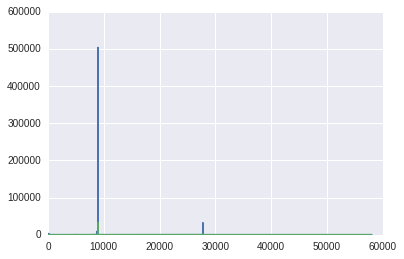

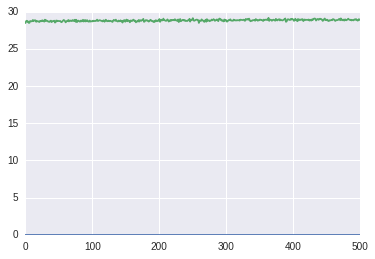

(128, 32, 32, 3)


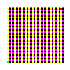

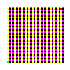

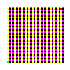

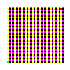

Iter: 60000
D loss: 4.153e-13
G_loss: 29.16
()


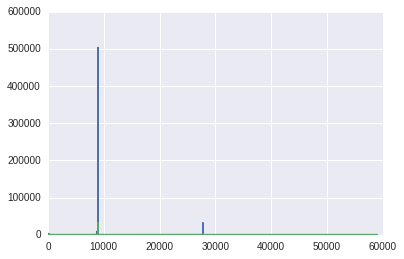

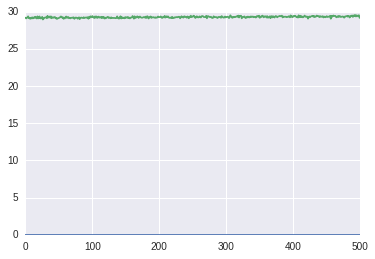

(128, 32, 32, 3)


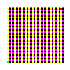

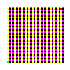

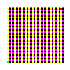

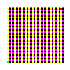

Iter: 61000
D loss: 1.925e-13
G_loss: 29.87
()


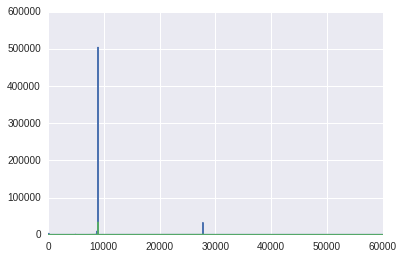

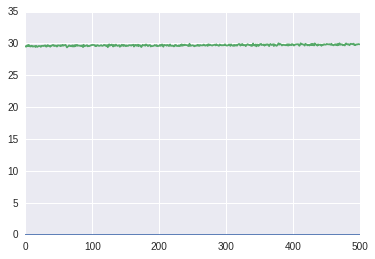

(128, 32, 32, 3)


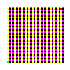

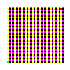

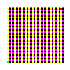

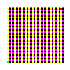

Iter: 62000
D loss: 2.415e-13
G_loss: 30.35
()


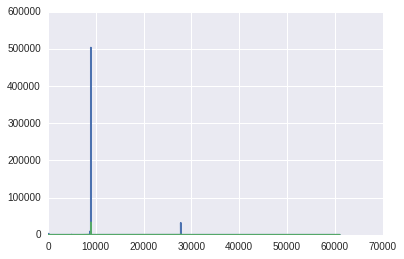

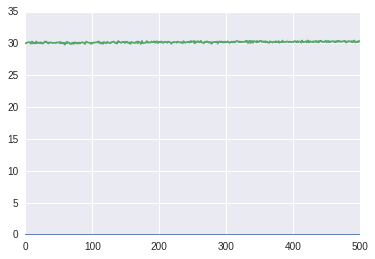

(128, 32, 32, 3)


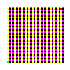

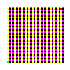

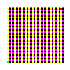

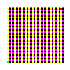

Iter: 63000
D loss: 7.549e-14
G_loss: 30.8
()


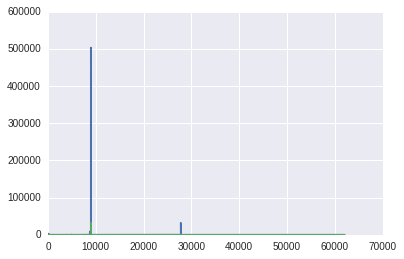

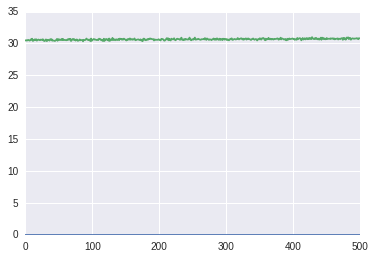

(128, 32, 32, 3)


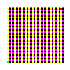

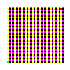

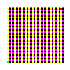

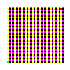

Iter: 64000
D loss: 6.186e-14
G_loss: 31.09
()


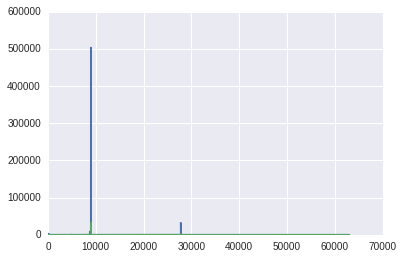

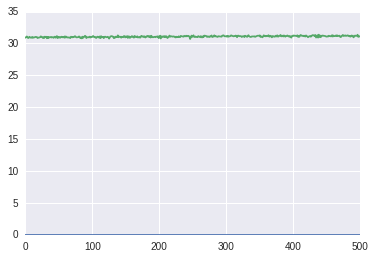

(128, 32, 32, 3)


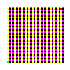

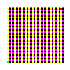

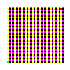

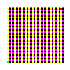

Iter: 65000
D loss: 3.356e-14
G_loss: 31.77
()


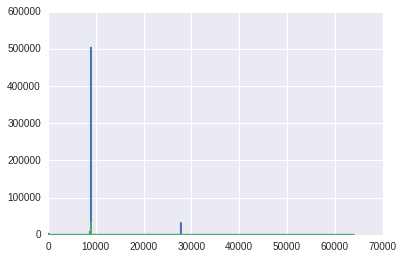

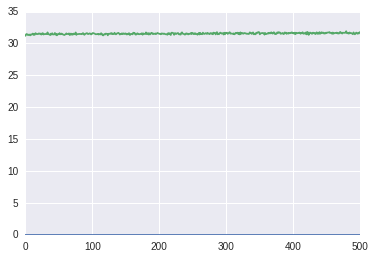

(128, 32, 32, 3)


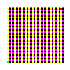

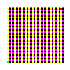

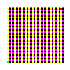

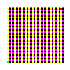

Iter: 66000
D loss: 1.565e-14
G_loss: 31.93
()


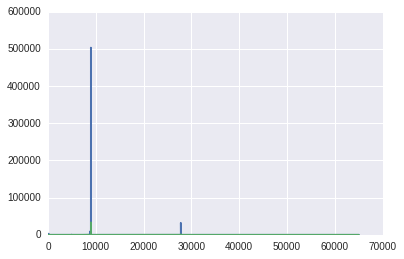

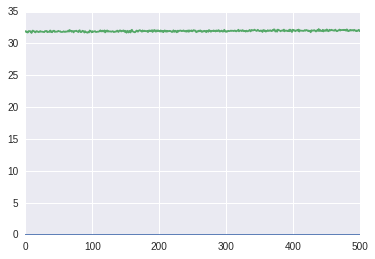

(128, 32, 32, 3)


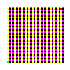

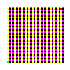

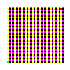

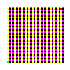

Iter: 67000
D loss: 1.7e-14
G_loss: 32.6
()


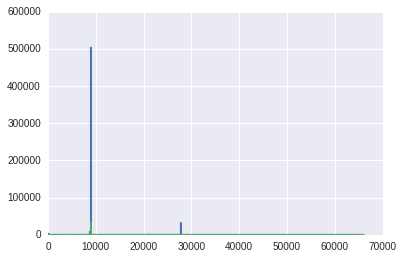

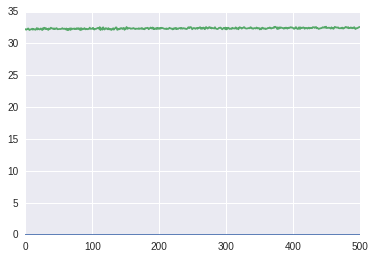

(128, 32, 32, 3)


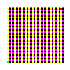

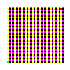

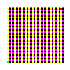

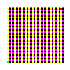

Iter: 68000
D loss: 8.375e-15
G_loss: 32.74
()


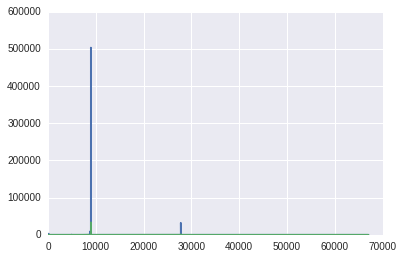

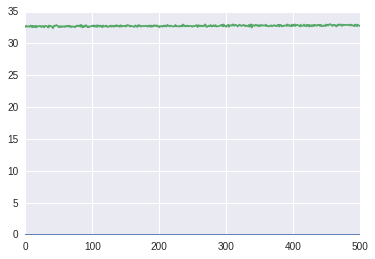

(128, 32, 32, 3)


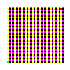

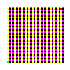

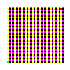

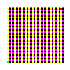

Iter: 69000
D loss: 7.412e-15
G_loss: 33.35
()


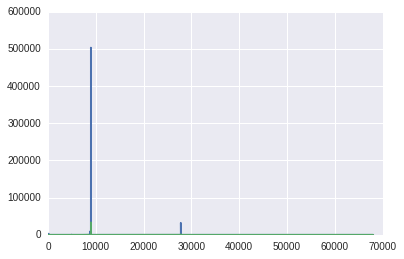

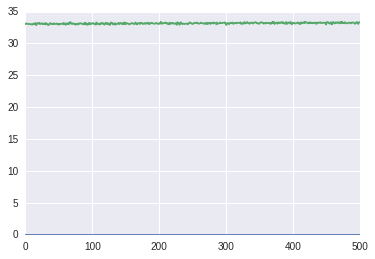

(128, 32, 32, 3)


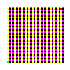

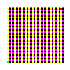

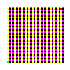

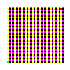

Iter: 70000
D loss: 3.674e-15
G_loss: 33.72
()


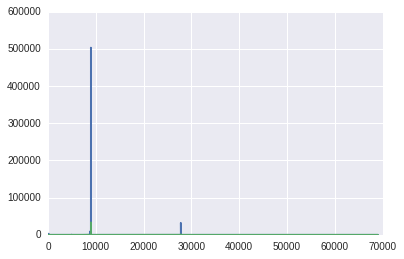

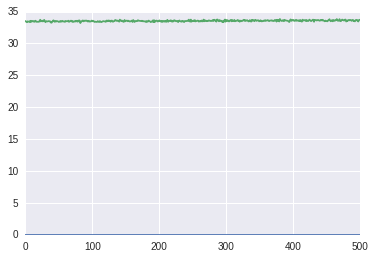

(128, 32, 32, 3)


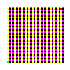

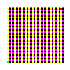

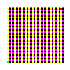

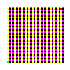

Iter: 71000
D loss: 2.615e-15
G_loss: 33.93
()


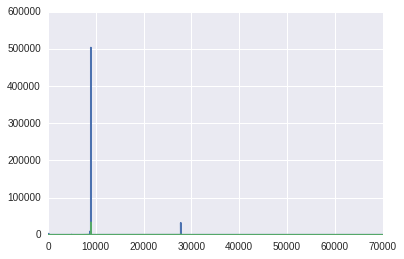

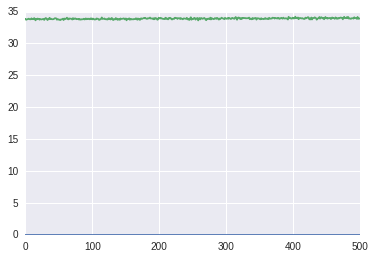

(128, 32, 32, 3)


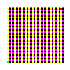

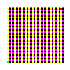

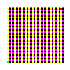

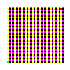

Iter: 72000
D loss: 2.209e-15
G_loss: 34.27
()


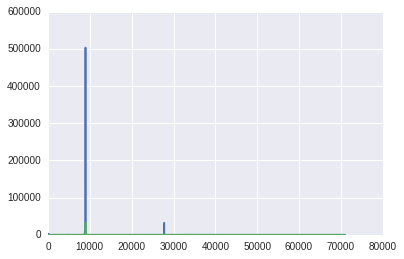

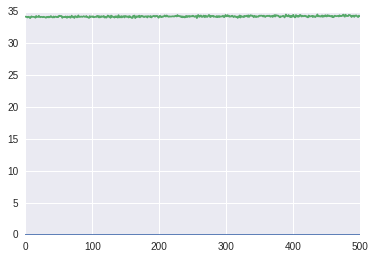

(128, 32, 32, 3)


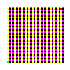

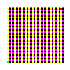

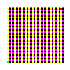

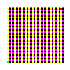

Iter: 73000
D loss: 1.346e-15
G_loss: 34.6
()


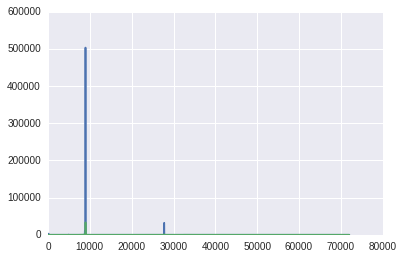

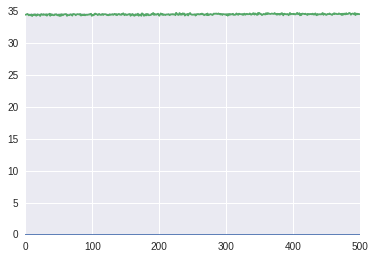

(128, 32, 32, 3)


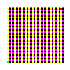

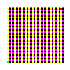

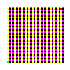

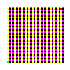

Iter: 74000
D loss: 1.26e-15
G_loss: 34.95
()


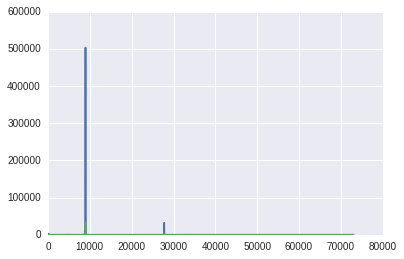

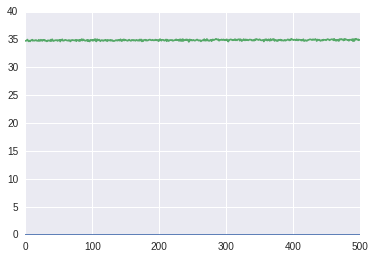

(128, 32, 32, 3)


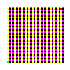

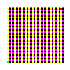

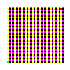

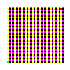

Iter: 75000
D loss: 8.397e-16
G_loss: 35.34
()


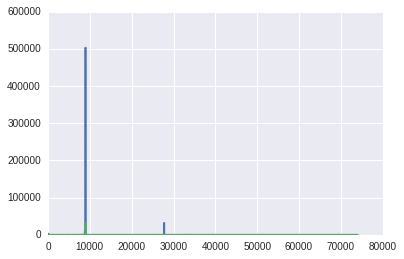

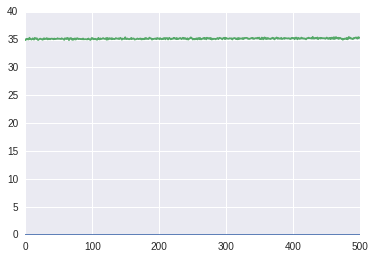

(128, 32, 32, 3)


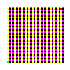

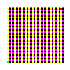

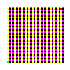

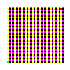

Iter: 76000
D loss: 6.146e-16
G_loss: 35.59
()


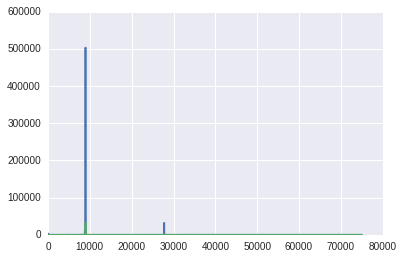

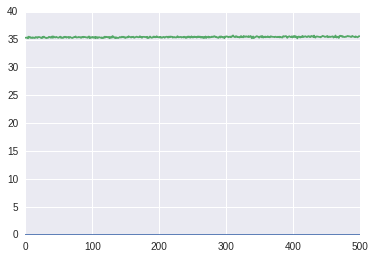

(128, 32, 32, 3)


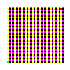

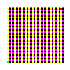

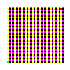

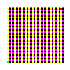

Iter: 77000
D loss: 5.356e-16
G_loss: 35.93
()


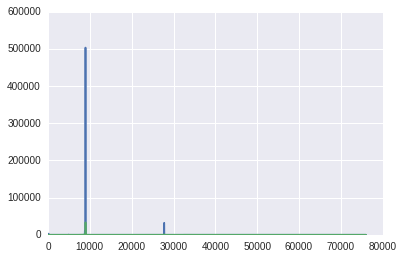

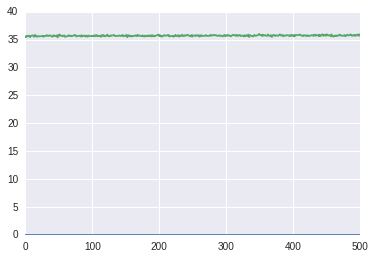

(128, 32, 32, 3)


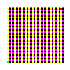

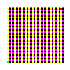

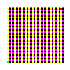

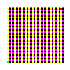

Iter: 78000
D loss: 3.083e-16
G_loss: 35.97
()


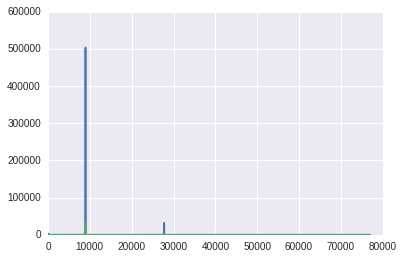

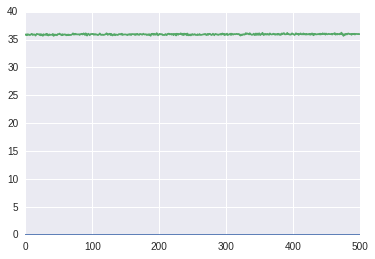

(128, 32, 32, 3)


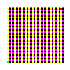

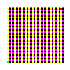

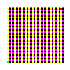

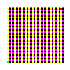

Iter: 79000
D loss: 2.668e-16
G_loss: 36.31
()


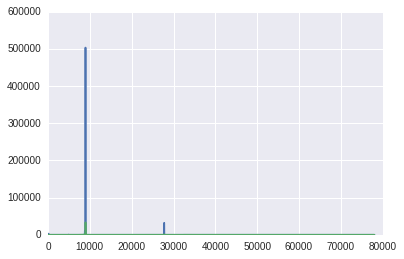

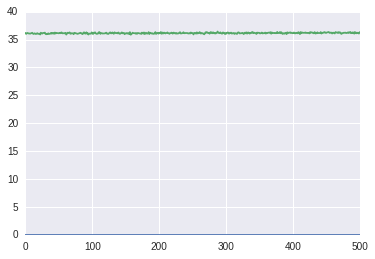

(128, 32, 32, 3)


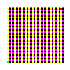

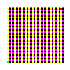

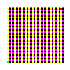

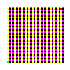

Iter: 80000
D loss: 2.621e-16
G_loss: 36.5
()


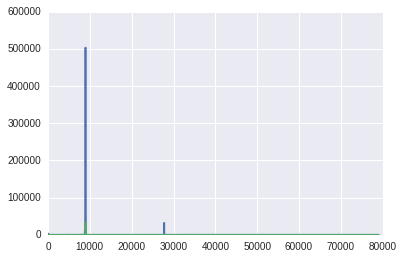

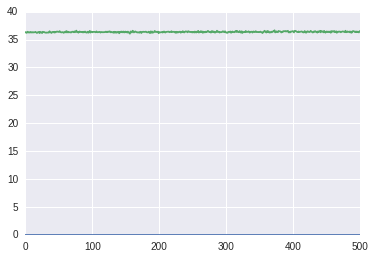

(128, 32, 32, 3)


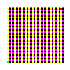

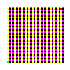

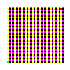

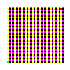

Iter: 81000
D loss: 2.534e-16
G_loss: 36.46
()


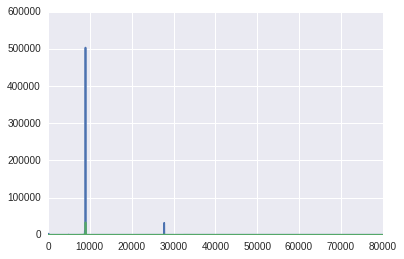

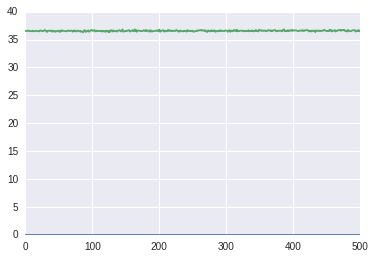

(128, 32, 32, 3)


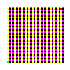

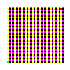

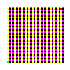

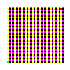

Iter: 82000
D loss: 1.656e-16
G_loss: 36.83
()


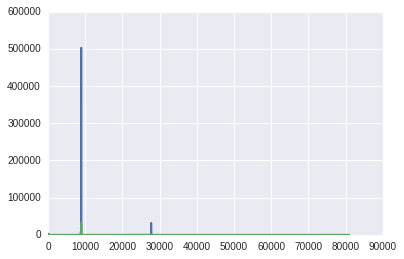

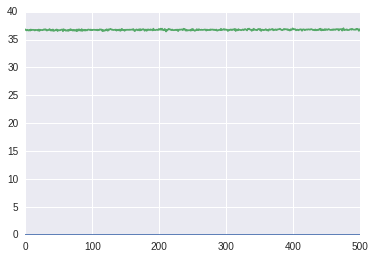

(128, 32, 32, 3)


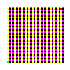

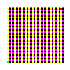

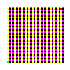

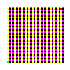

Iter: 83000
D loss: 2.001e-16
G_loss: 36.99
()


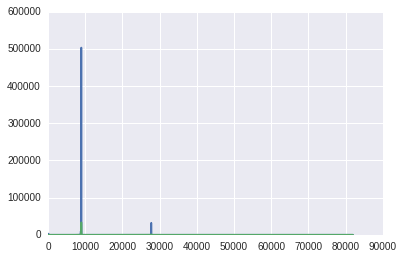

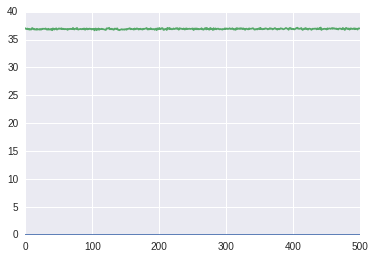

(128, 32, 32, 3)


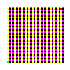

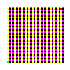

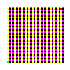

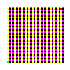

Iter: 84000
D loss: 1.087e-16
G_loss: 37.13
()


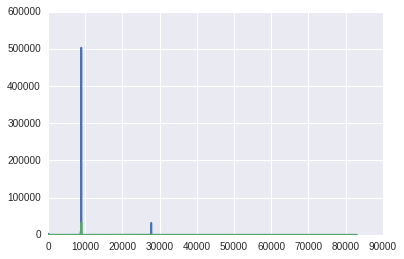

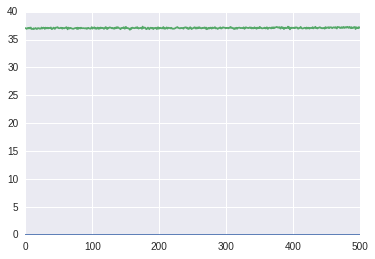

(128, 32, 32, 3)


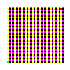

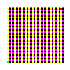

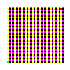

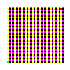

Iter: 85000
D loss: 1.093e-16
G_loss: 37.32
()


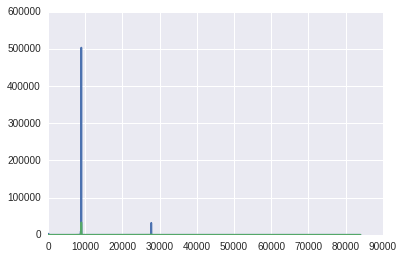

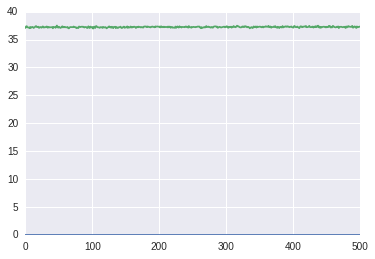

(128, 32, 32, 3)


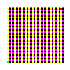

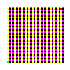

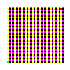

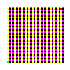

Iter: 86000
D loss: 9.758e-17
G_loss: 37.46
()


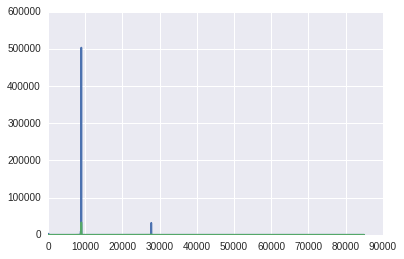

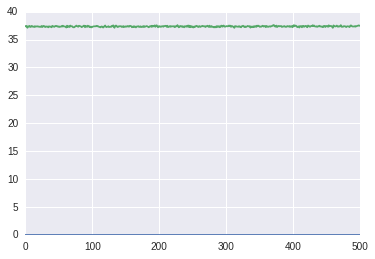

(128, 32, 32, 3)


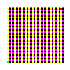

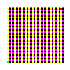

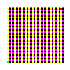

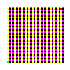

Iter: 87000
D loss: 9.123e-17
G_loss: 37.5
()


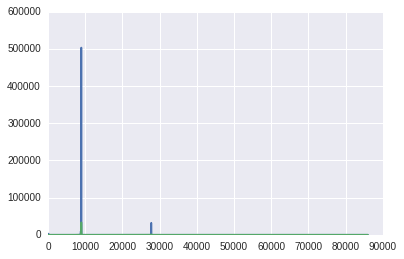

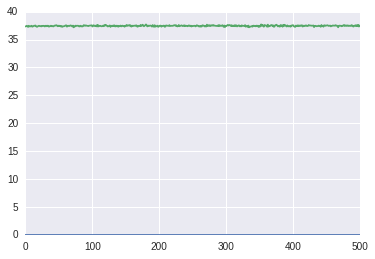

(128, 32, 32, 3)


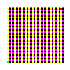

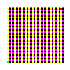

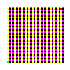

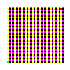

Iter: 88000
D loss: 8.318e-17
G_loss: 37.42
()


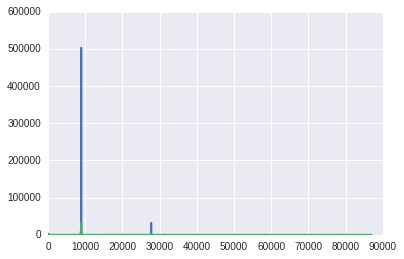

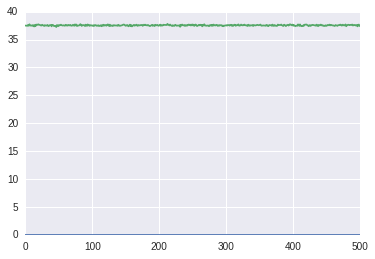

(128, 32, 32, 3)


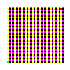

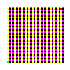

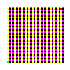

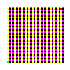

Iter: 89000
D loss: 7.332e-17
G_loss: 37.72
()


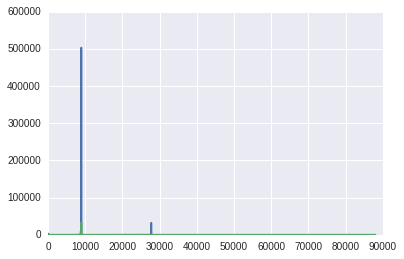

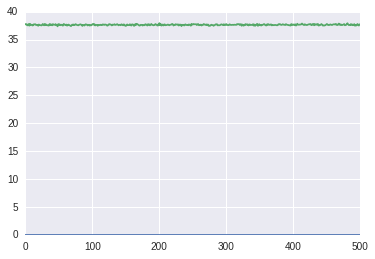

(128, 32, 32, 3)


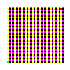

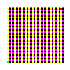

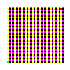

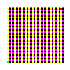

Iter: 90000
D loss: 5.834e-17
G_loss: 37.79
()


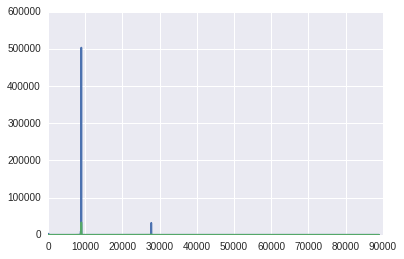

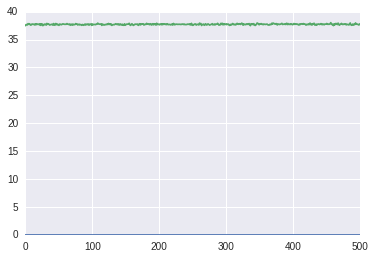

(128, 32, 32, 3)


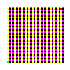

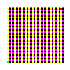

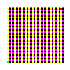

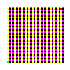

Iter: 91000
D loss: 6.272e-17
G_loss: 37.82
()


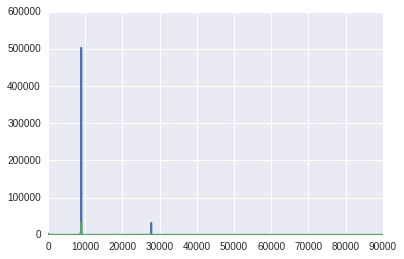

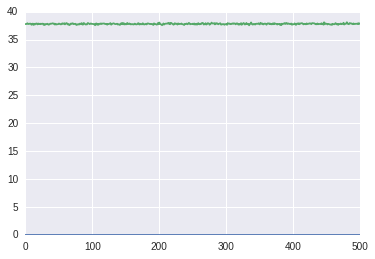

(128, 32, 32, 3)


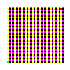

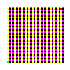

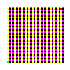

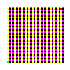

Iter: 92000
D loss: 5.849e-17
G_loss: 37.82
()


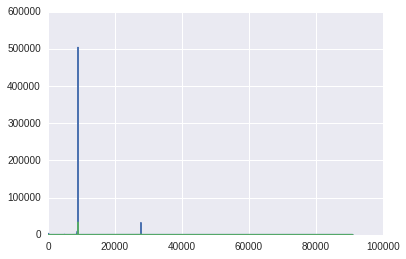

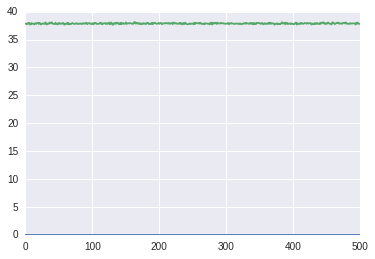

(128, 32, 32, 3)


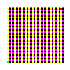

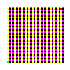

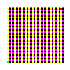

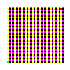

Iter: 93000
D loss: 6.691e-17
G_loss: 38.0
()


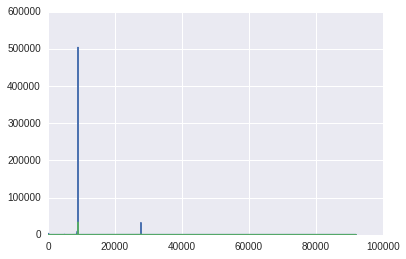

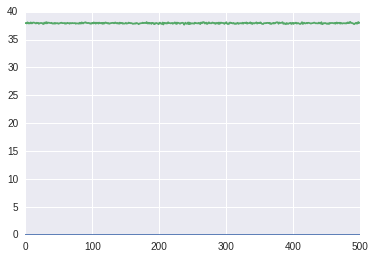

(128, 32, 32, 3)


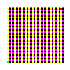

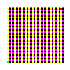

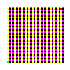

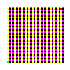

Iter: 94000
D loss: 6.431e-17
G_loss: 38.0
()


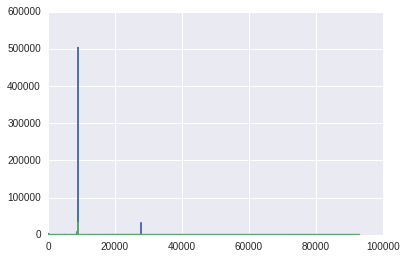

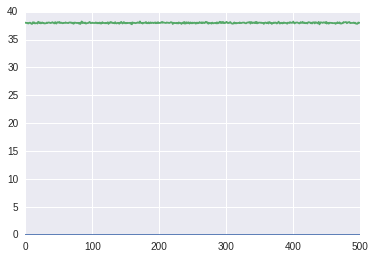

(128, 32, 32, 3)


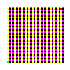

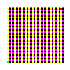

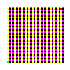

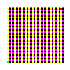

Iter: 95000
D loss: 5.532e-17
G_loss: 38.07
()


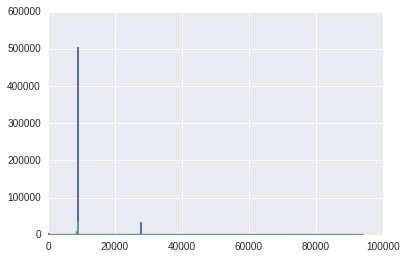

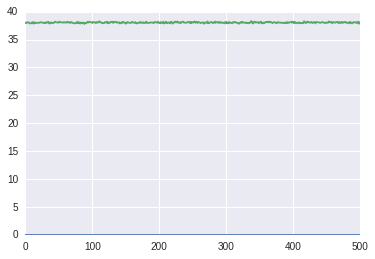

(128, 32, 32, 3)


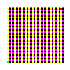

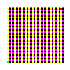

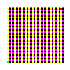

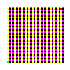

Iter: 96000
D loss: 4.937e-17
G_loss: 38.24
()


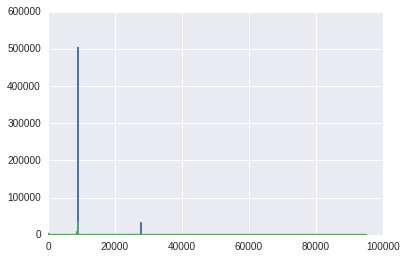

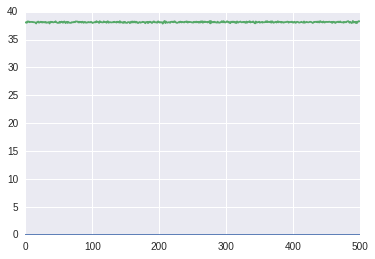

(128, 32, 32, 3)


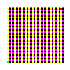

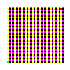

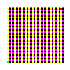

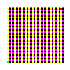

Iter: 97000
D loss: 6.102e-17
G_loss: 38.05
()


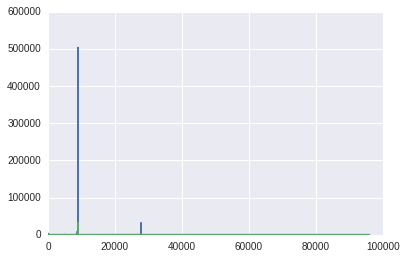

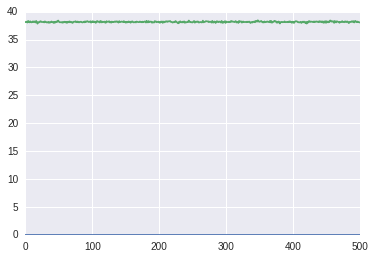

(128, 32, 32, 3)


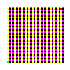

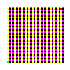

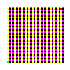

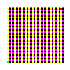

Iter: 98000
D loss: 4.846e-17
G_loss: 38.36
()


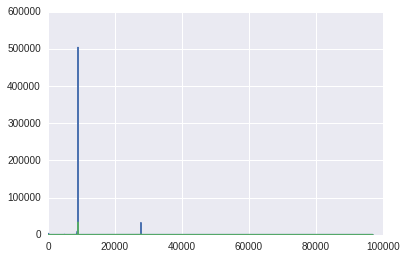

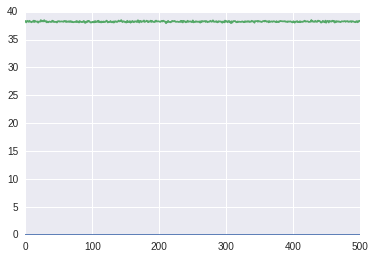

(128, 32, 32, 3)


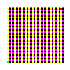

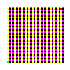

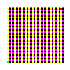

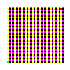

Iter: 99000
D loss: 4.069e-17
G_loss: 38.16
()


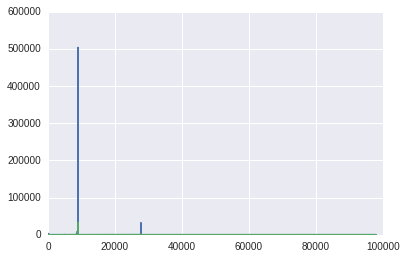

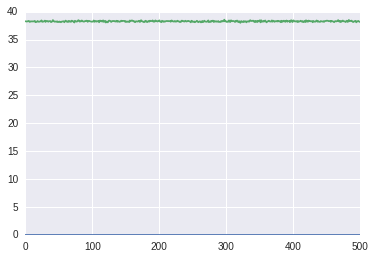

(128, 32, 32, 3)


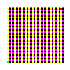

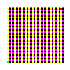

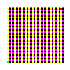

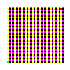

Iter: 100000
D loss: 3.386e-17
G_loss: 38.18
()


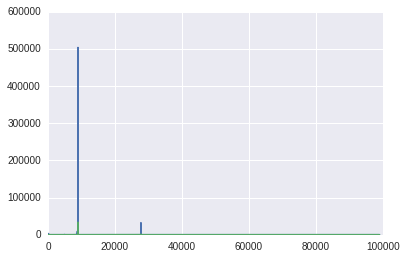

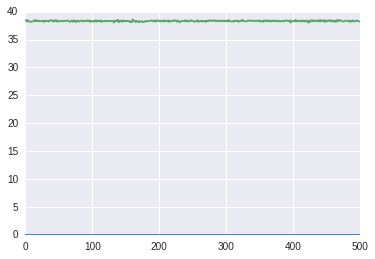

(128, 32, 32, 3)


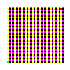

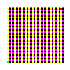

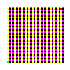

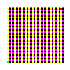

Iter: 101000
D loss: 2.762e-17
G_loss: 38.42
()


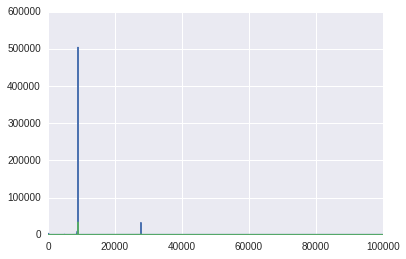

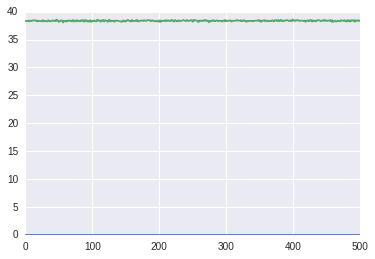

(128, 32, 32, 3)


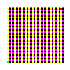

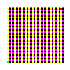

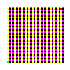

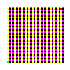

Iter: 102000
D loss: 3.021e-17
G_loss: 38.37
()


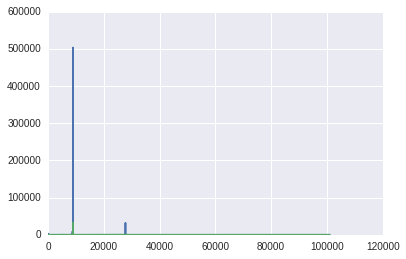

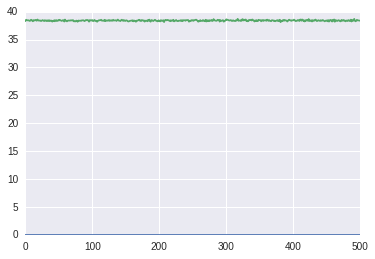

(128, 32, 32, 3)


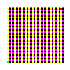

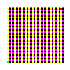

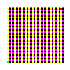

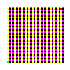

Iter: 103000
D loss: 2.871e-17
G_loss: 38.4
()


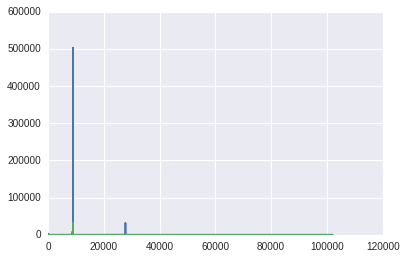

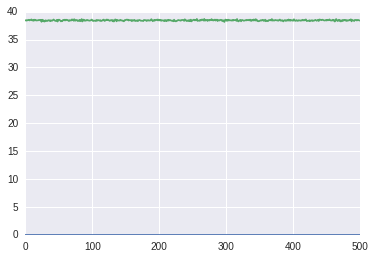

(128, 32, 32, 3)


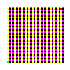

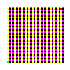

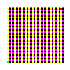

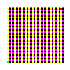

Iter: 104000
D loss: 3.104e-17
G_loss: 38.43
()


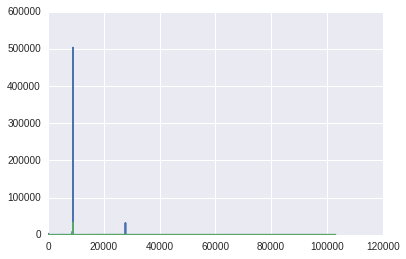

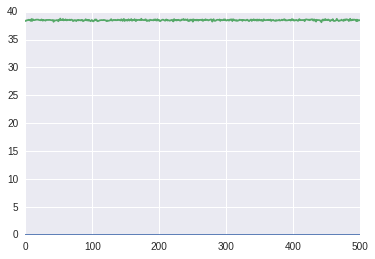

(128, 32, 32, 3)


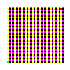

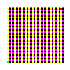

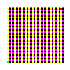

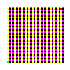

Iter: 105000
D loss: 3.748e-17
G_loss: 38.43
()


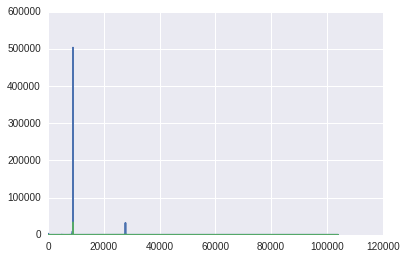

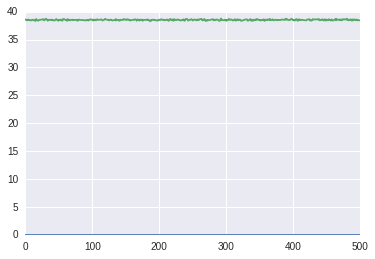

(128, 32, 32, 3)


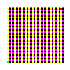

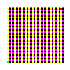

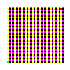

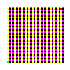

Iter: 106000
D loss: 3.644e-17
G_loss: 38.47
()


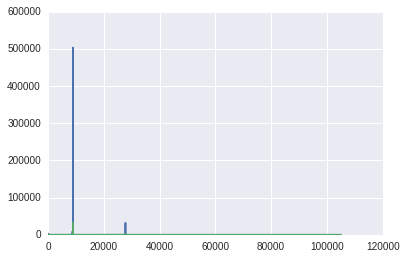

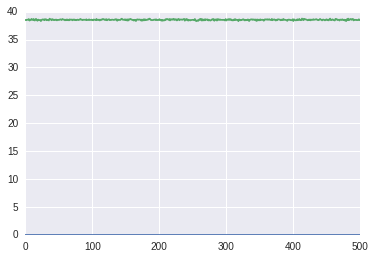

(128, 32, 32, 3)


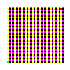

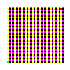

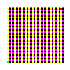

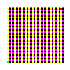

Iter: 107000
D loss: 2.997e-17
G_loss: 38.64
()


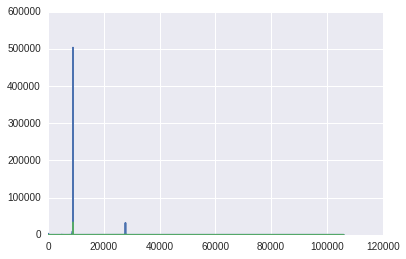

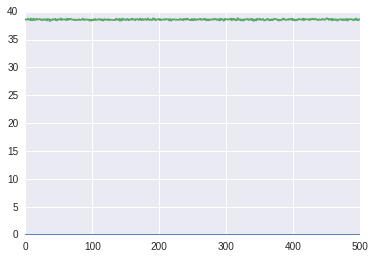

(128, 32, 32, 3)


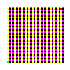

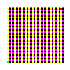

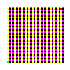

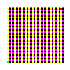

Iter: 108000
D loss: 0.0
G_loss: 122.2
()


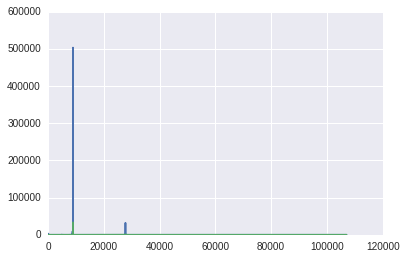

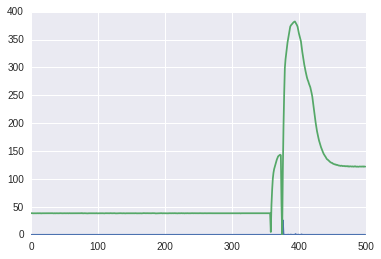

(128, 32, 32, 3)


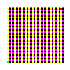

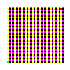

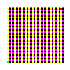

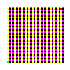

Iter: 109000
D loss: 0.0
G_loss: 122.4
()


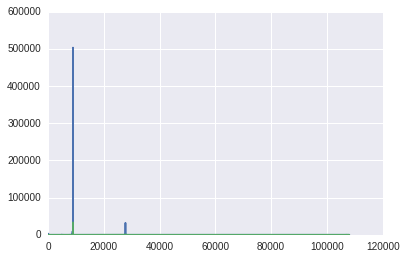

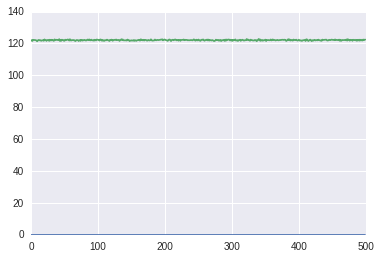

(128, 32, 32, 3)


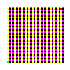

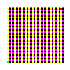

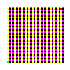

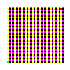

Iter: 110000
D loss: 0.0
G_loss: 122.4
()


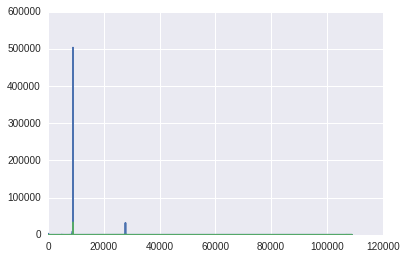

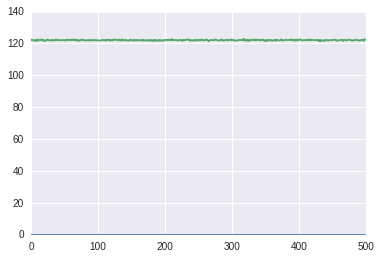

(128, 32, 32, 3)


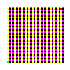

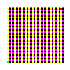

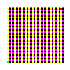

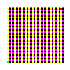

Iter: 111000
D loss: 0.0
G_loss: 121.9
()


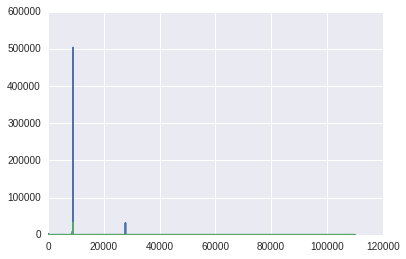

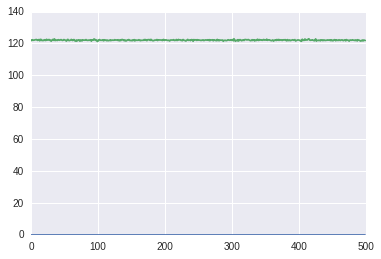

(128, 32, 32, 3)


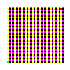

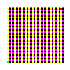

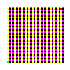

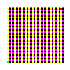

Iter: 112000
D loss: 0.0
G_loss: 122.0
()


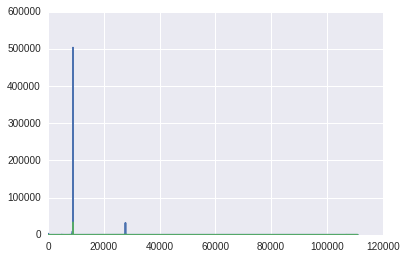

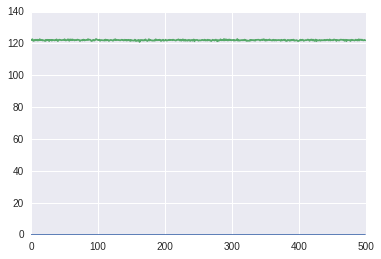

(128, 32, 32, 3)


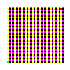

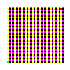

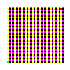

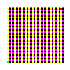

Iter: 113000
D loss: 0.0
G_loss: 122.2
()


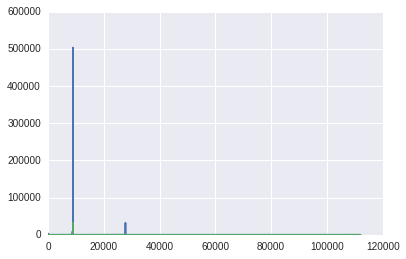

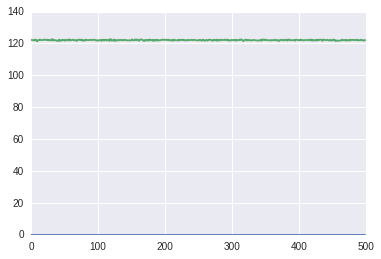

(128, 32, 32, 3)


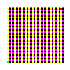

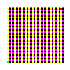

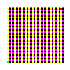

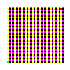

Iter: 114000
D loss: 0.0
G_loss: 122.5
()


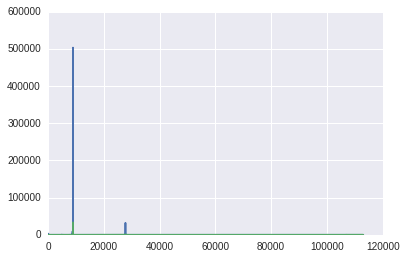

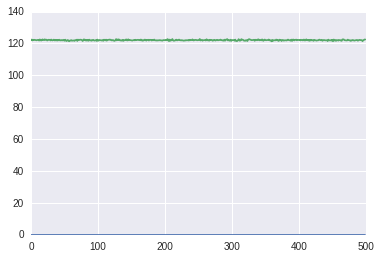

(128, 32, 32, 3)


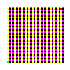

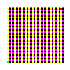

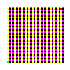

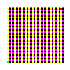

Iter: 115000
D loss: 0.0
G_loss: 122.4
()


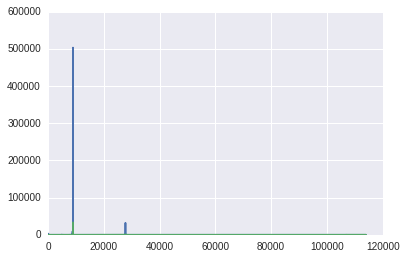

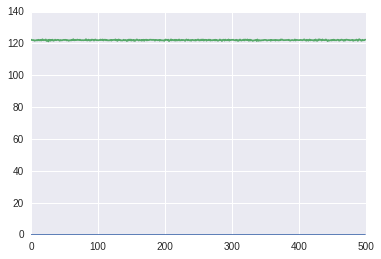

(128, 32, 32, 3)


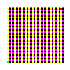

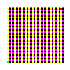

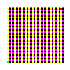

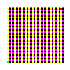

Iter: 116000
D loss: 0.0
G_loss: 121.9
()


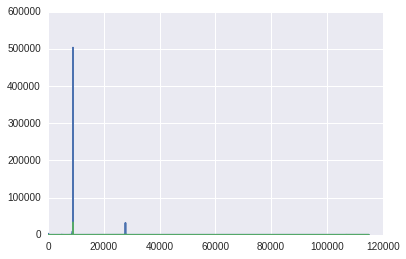

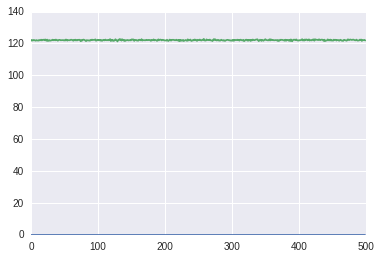

(128, 32, 32, 3)


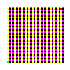

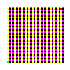

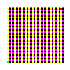

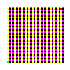

Iter: 117000
D loss: 0.0
G_loss: 122.1
()


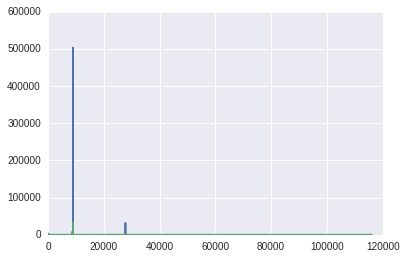

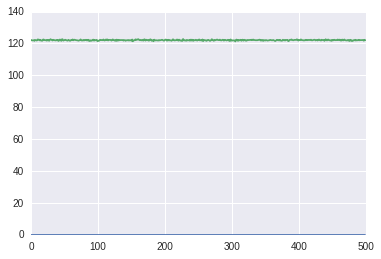

(128, 32, 32, 3)


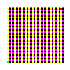

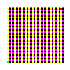

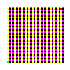

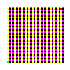

Iter: 118000
D loss: 0.0
G_loss: 121.9
()


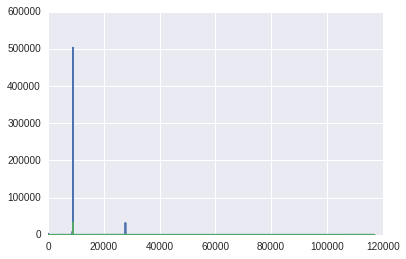

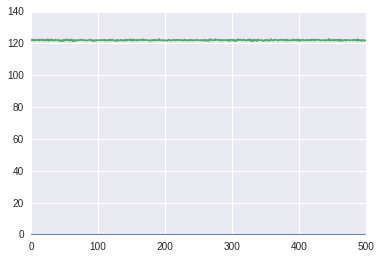

(128, 32, 32, 3)


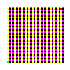

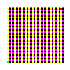

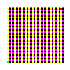

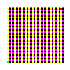

Iter: 119000
D loss: 0.0
G_loss: 121.7
()


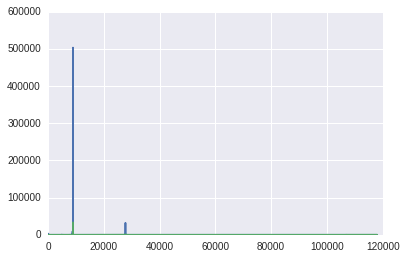

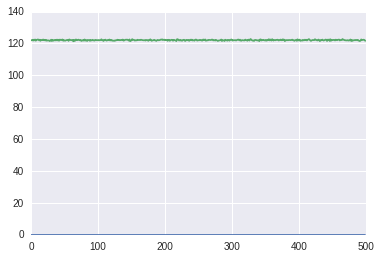

(128, 32, 32, 3)


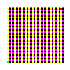

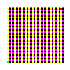

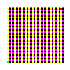

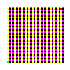

Iter: 120000
D loss: 0.0
G_loss: 122.5
()


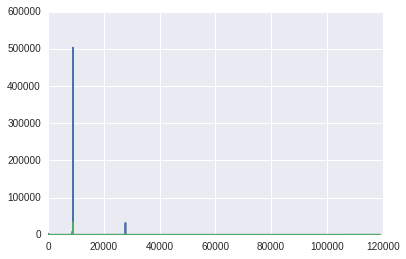

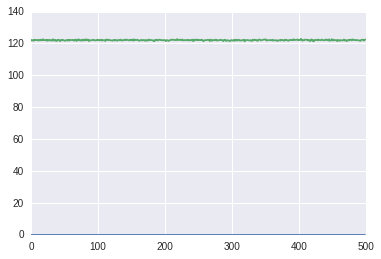

(128, 32, 32, 3)


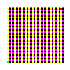

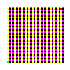

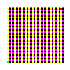

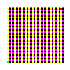

Iter: 121000
D loss: 0.0
G_loss: 122.0
()


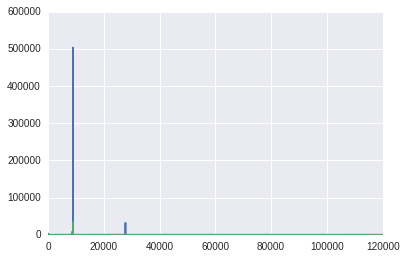

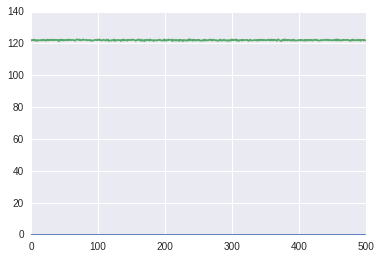

(128, 32, 32, 3)


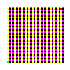

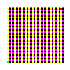

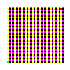

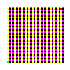

Iter: 122000
D loss: 0.0
G_loss: 122.4
()


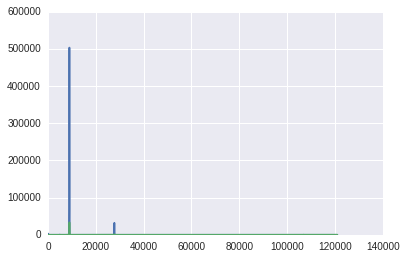

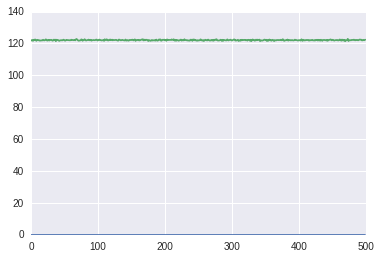

(128, 32, 32, 3)


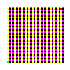

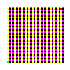

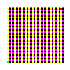

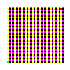

Iter: 123000
D loss: 0.0
G_loss: 122.0
()


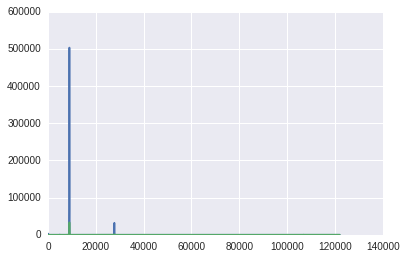

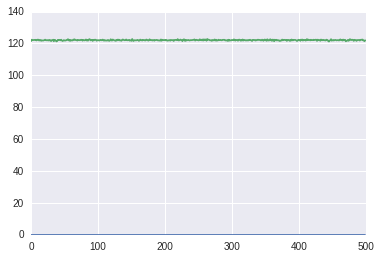

(128, 32, 32, 3)


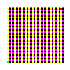

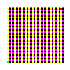

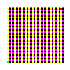

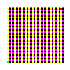

Iter: 124000
D loss: 0.0
G_loss: 122.4
()


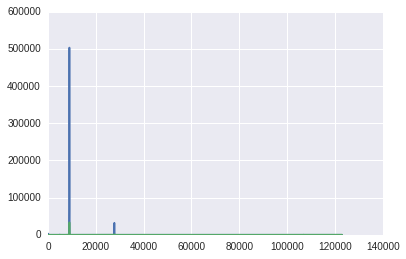

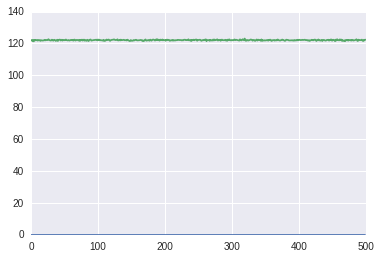

(128, 32, 32, 3)


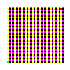

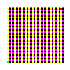

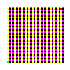

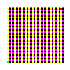

Iter: 125000
D loss: 0.0
G_loss: 121.9
()


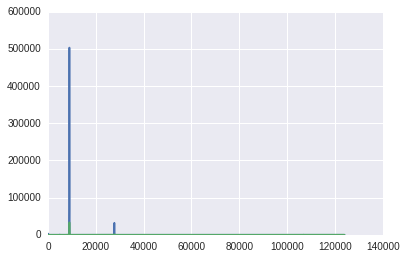

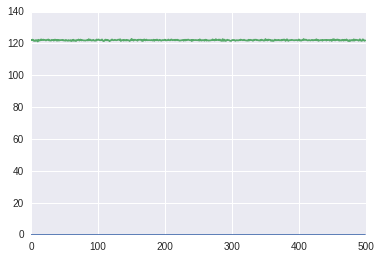

(128, 32, 32, 3)


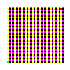

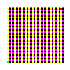

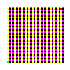

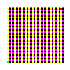

Iter: 126000
D loss: 0.0
G_loss: 122.0
()


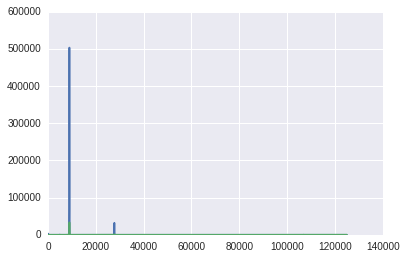

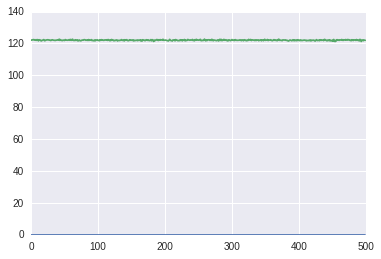

(128, 32, 32, 3)


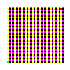

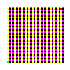

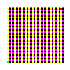

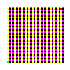

Iter: 127000
D loss: 0.0
G_loss: 122.3
()


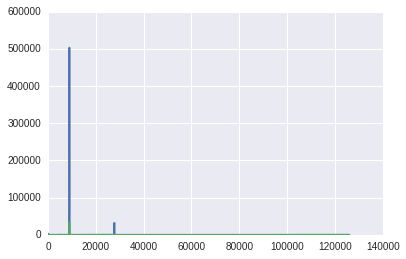

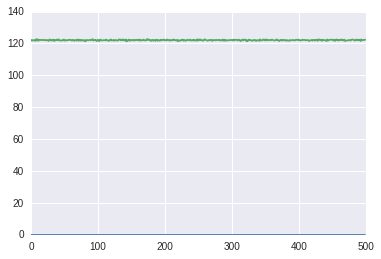

(128, 32, 32, 3)


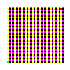

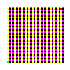

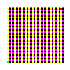

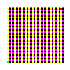

Iter: 128000
D loss: 0.0
G_loss: 121.9
()


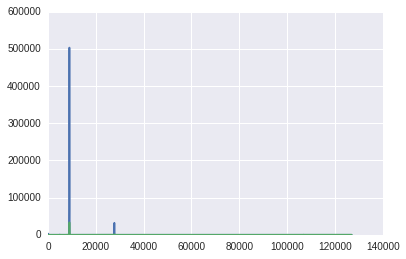

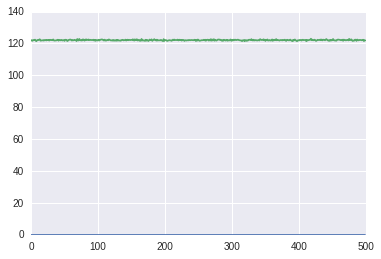

(128, 32, 32, 3)


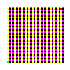

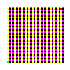

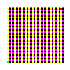

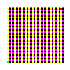

Iter: 129000
D loss: 0.0
G_loss: 121.6
()


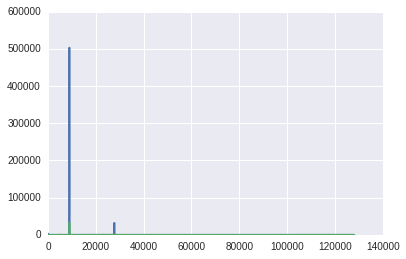

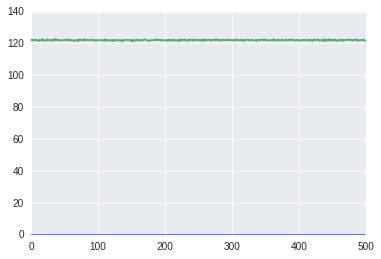

(128, 32, 32, 3)


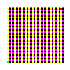

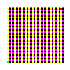

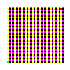

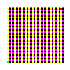

Iter: 130000
D loss: 0.0
G_loss: 121.9
()


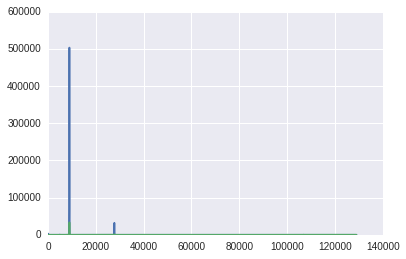

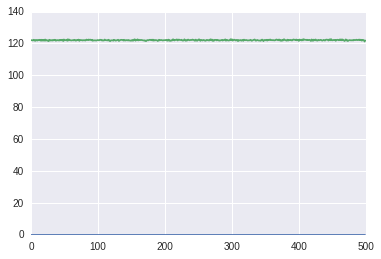

(128, 32, 32, 3)


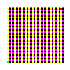

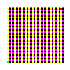

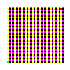

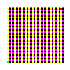

Iter: 131000
D loss: 0.0
G_loss: 122.5
()


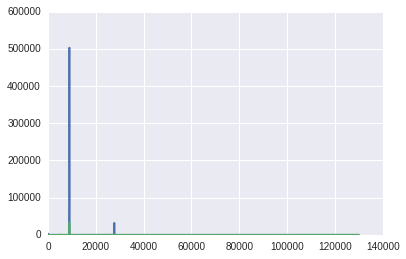

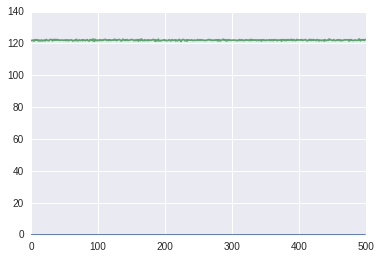

(128, 32, 32, 3)


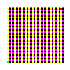

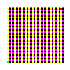

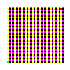

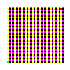

Iter: 132000
D loss: 0.0
G_loss: 121.6
()


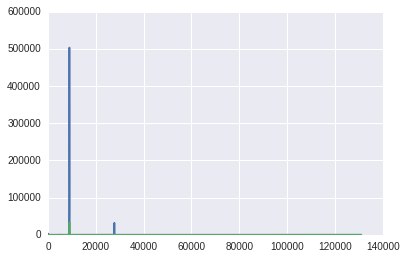

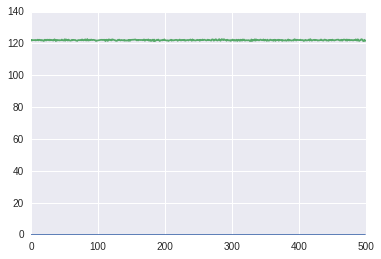

(128, 32, 32, 3)


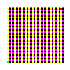

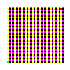

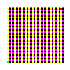

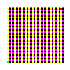

Iter: 133000
D loss: 0.0
G_loss: 122.1
()


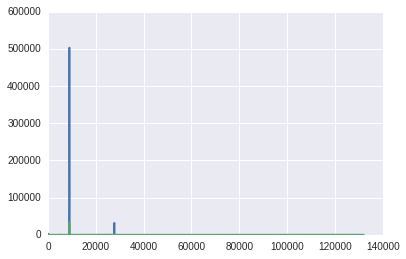

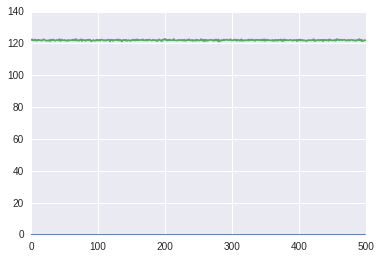

(128, 32, 32, 3)


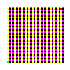

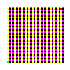

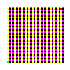

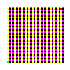

Iter: 134000
D loss: 0.0
G_loss: 122.1
()


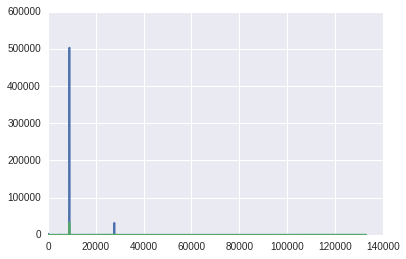

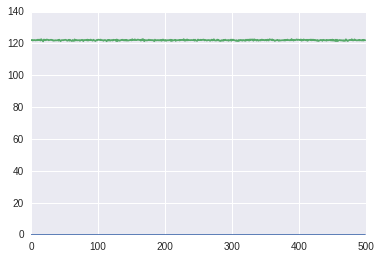

(128, 32, 32, 3)


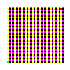

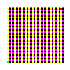

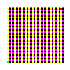

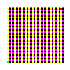

Iter: 135000
D loss: 0.0
G_loss: 122.3
()


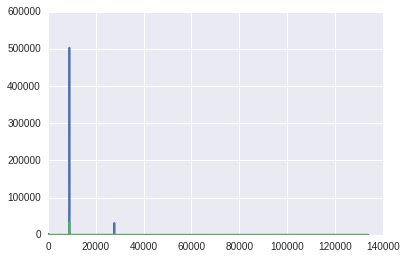

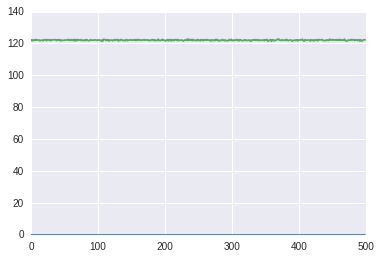

(128, 32, 32, 3)


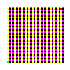

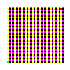

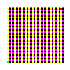

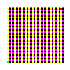

Iter: 136000
D loss: 0.0
G_loss: 122.1
()


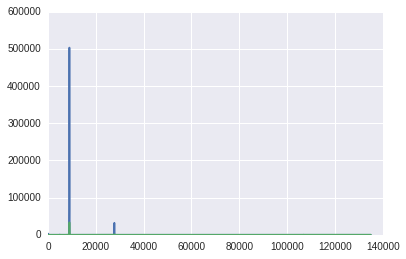

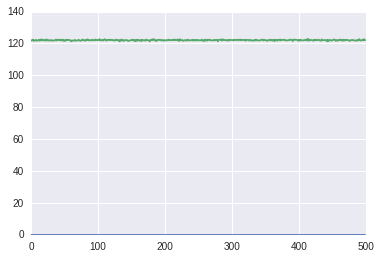

(128, 32, 32, 3)


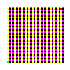

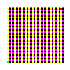

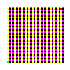

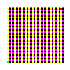

Iter: 137000
D loss: 0.0
G_loss: 122.4
()


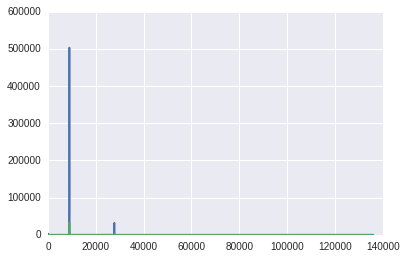

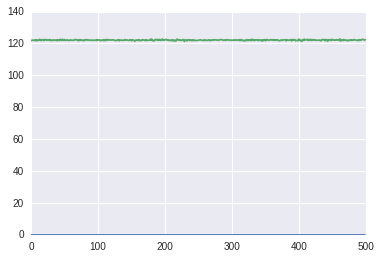

(128, 32, 32, 3)


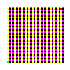

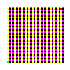

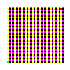

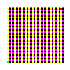

Iter: 138000
D loss: 0.0
G_loss: 122.4
()


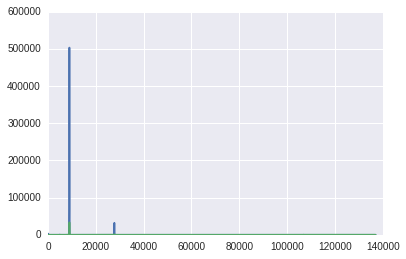

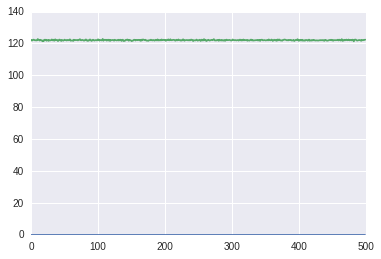

(128, 32, 32, 3)


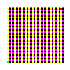

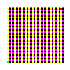

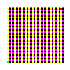

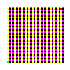

Iter: 139000
D loss: 0.0
G_loss: 122.0
()


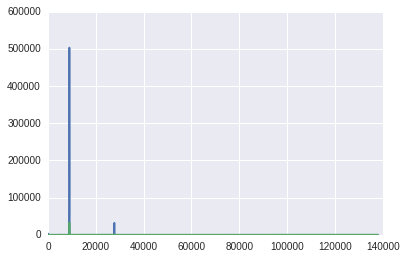

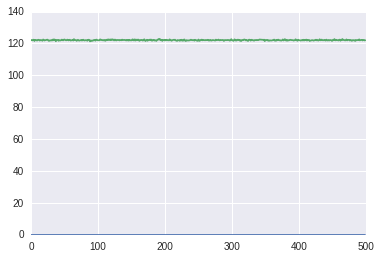

(128, 32, 32, 3)


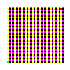

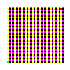

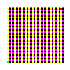

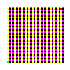

Iter: 140000
D loss: 0.0
G_loss: 121.9
()


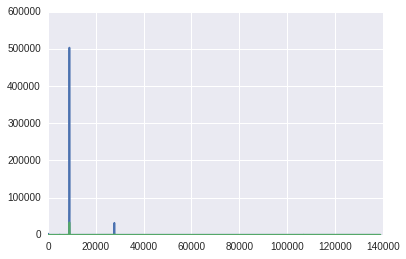

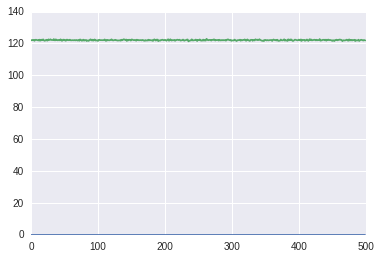

(128, 32, 32, 3)


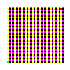

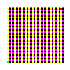

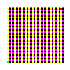

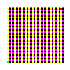

Iter: 141000
D loss: 0.0
G_loss: 121.8
()


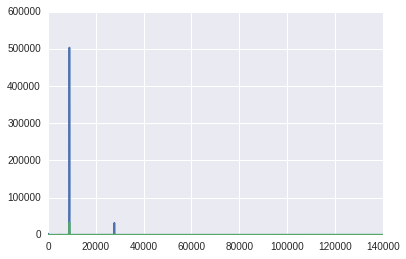

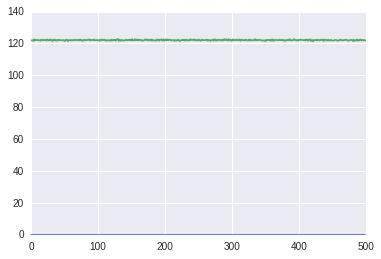

(128, 32, 32, 3)


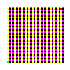

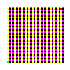

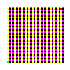

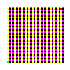

Iter: 142000
D loss: 0.0
G_loss: 121.8
()


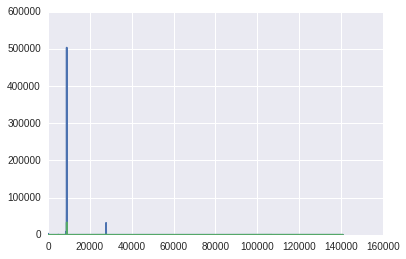

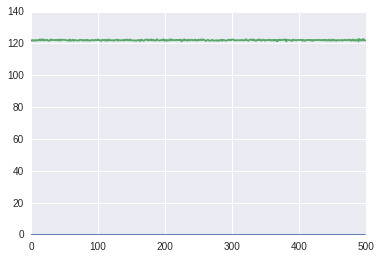

(128, 32, 32, 3)


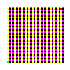

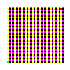

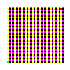

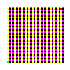

Iter: 143000
D loss: 0.0
G_loss: 122.2
()


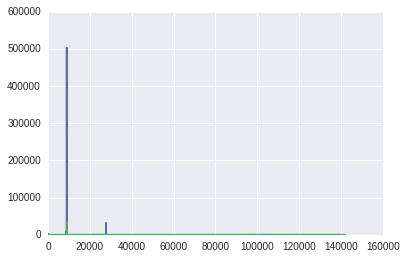

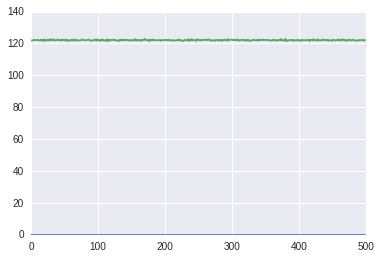

(128, 32, 32, 3)


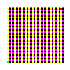

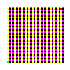

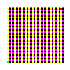

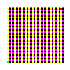

Iter: 144000
D loss: 0.0
G_loss: 122.1
()


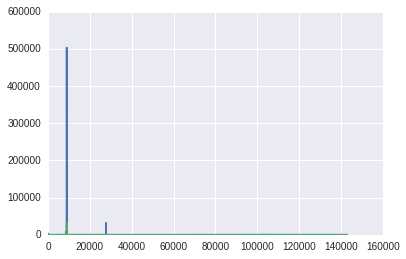

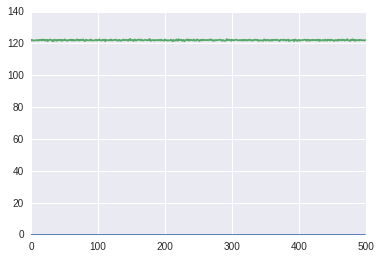

(128, 32, 32, 3)


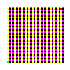

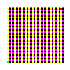

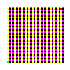

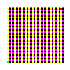

Iter: 145000
D loss: 0.0
G_loss: 121.8
()


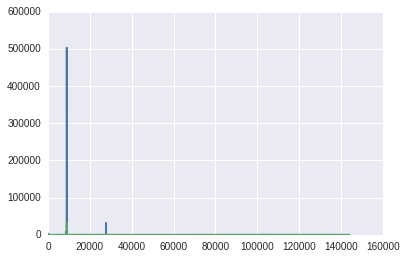

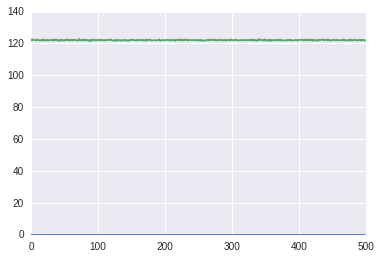

(128, 32, 32, 3)


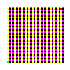

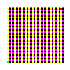

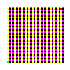

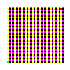

Iter: 146000
D loss: 0.0
G_loss: 121.8
()


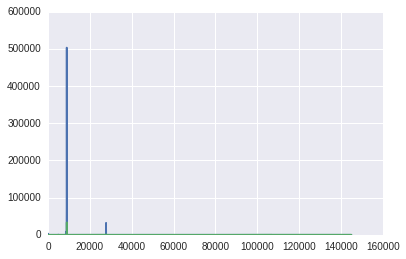

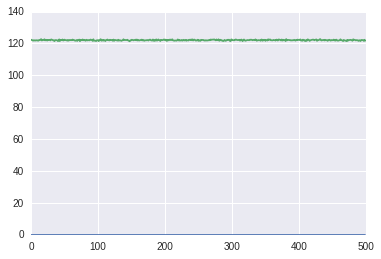

(128, 32, 32, 3)


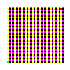

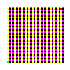

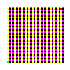

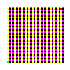

Iter: 147000
D loss: 0.0
G_loss: 122.1
()


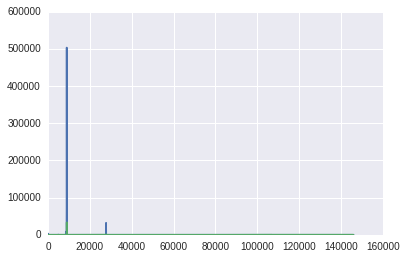

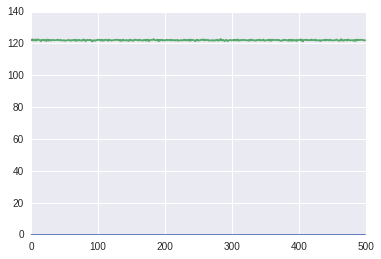

(128, 32, 32, 3)


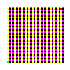

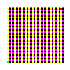

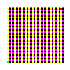

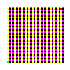

Iter: 148000
D loss: 0.0
G_loss: 121.6
()


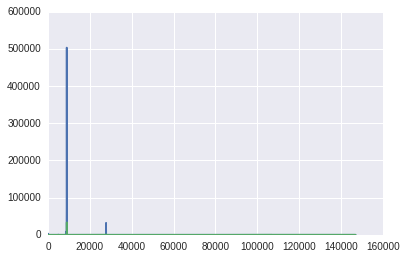

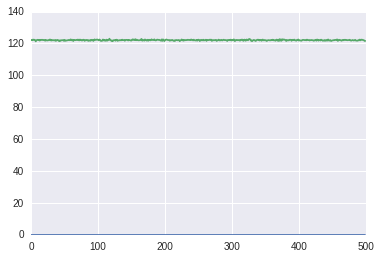

(128, 32, 32, 3)


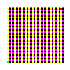

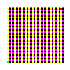

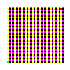

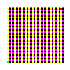

Iter: 149000
D loss: 0.0
G_loss: 122.1
()


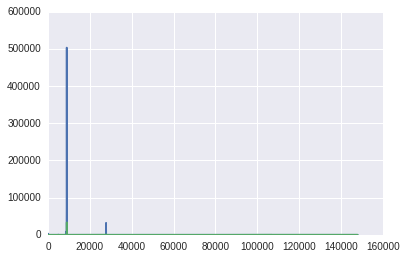

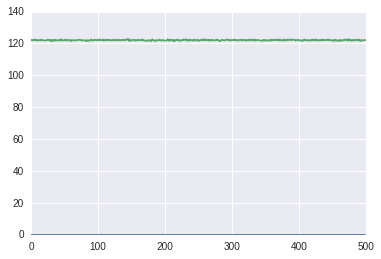

(128, 32, 32, 3)


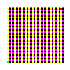

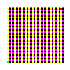

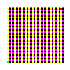

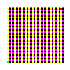

Iter: 150000
D loss: 0.0
G_loss: 122.4
()


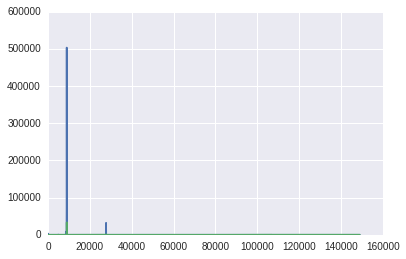

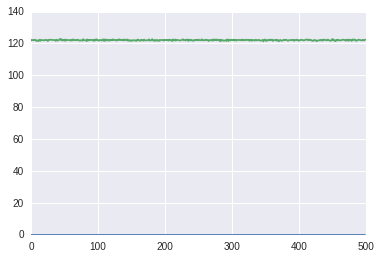

(128, 32, 32, 3)


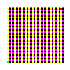

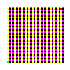

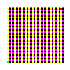

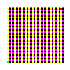

Iter: 151000
D loss: 0.0
G_loss: 122.7
()


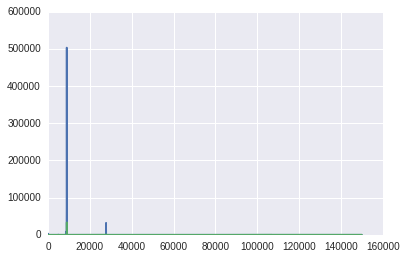

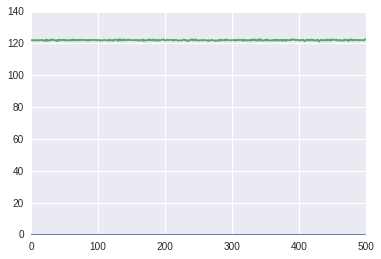

(128, 32, 32, 3)


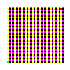

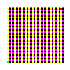

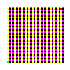

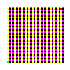

Iter: 152000
D loss: 0.0
G_loss: 122.0
()


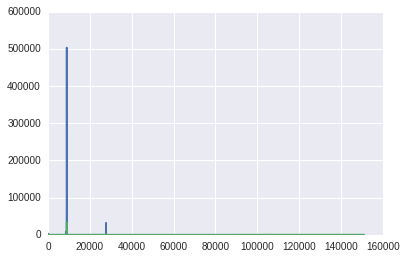

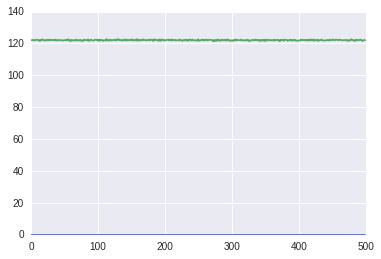

(128, 32, 32, 3)


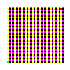

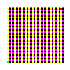

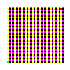

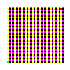

Iter: 153000
D loss: 0.0
G_loss: 121.7
()


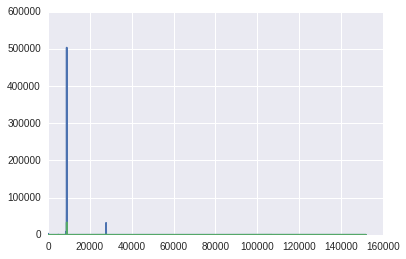

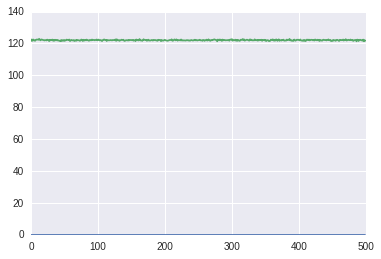

(128, 32, 32, 3)


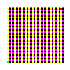

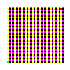

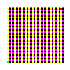

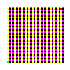

Iter: 154000
D loss: 0.0
G_loss: 122.3
()


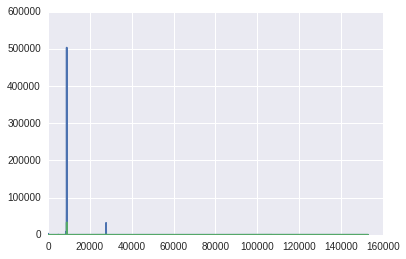

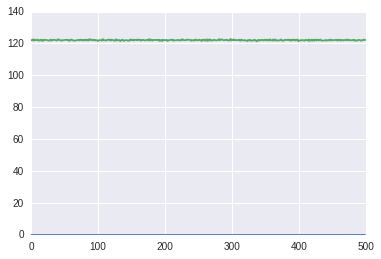

(128, 32, 32, 3)


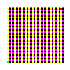

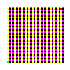

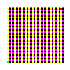

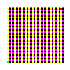

Iter: 155000
D loss: 0.0
G_loss: 121.7
()


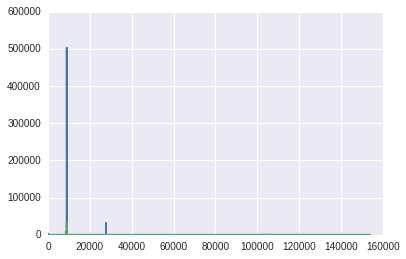

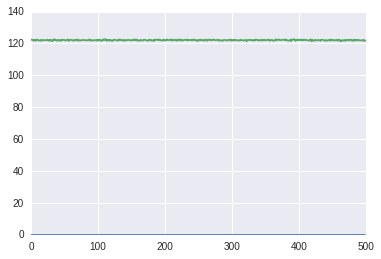

(128, 32, 32, 3)


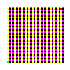

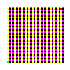

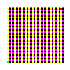

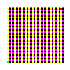

Iter: 156000
D loss: 0.0
G_loss: 122.0
()


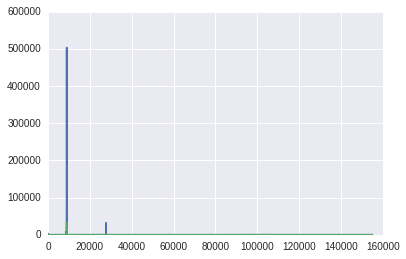

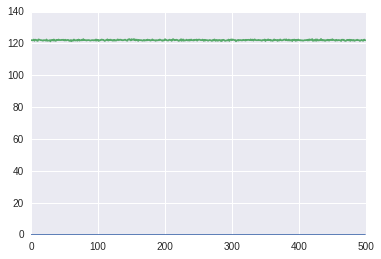

(128, 32, 32, 3)


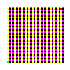

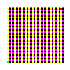

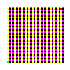

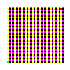

Iter: 157000
D loss: 0.0
G_loss: 122.1
()


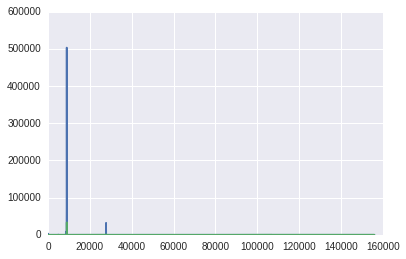

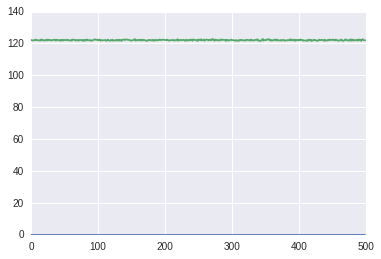

(128, 32, 32, 3)


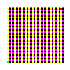

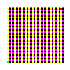

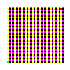

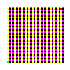

Iter: 158000
D loss: 0.0
G_loss: 122.2
()


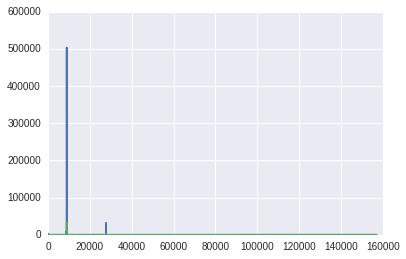

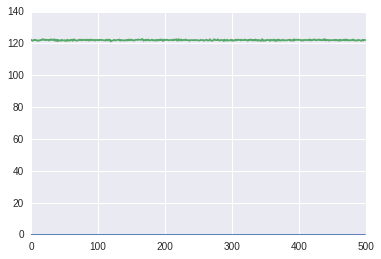

(128, 32, 32, 3)


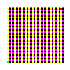

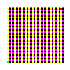

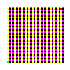

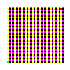

Iter: 159000
D loss: 0.0
G_loss: 122.2
()


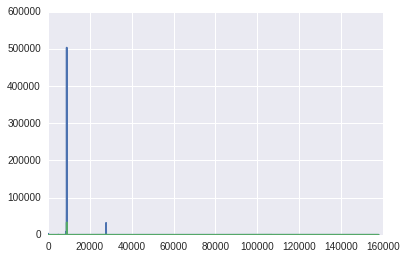

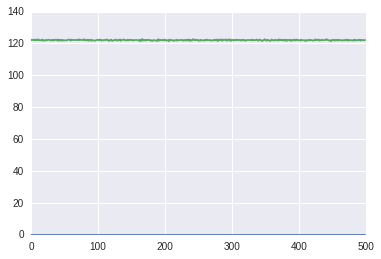

(128, 32, 32, 3)


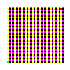

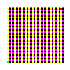

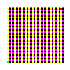

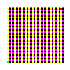

Iter: 160000
D loss: 0.0
G_loss: 122.1
()


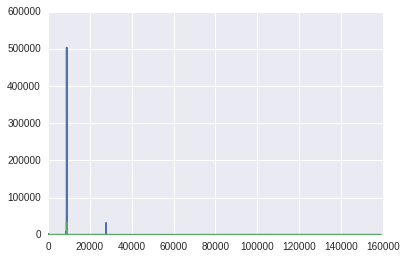

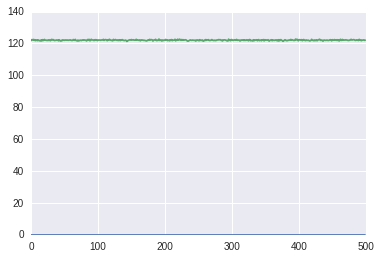

(128, 32, 32, 3)


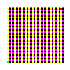

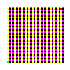

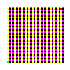

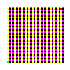

Iter: 161000
D loss: 0.0
G_loss: 122.1
()


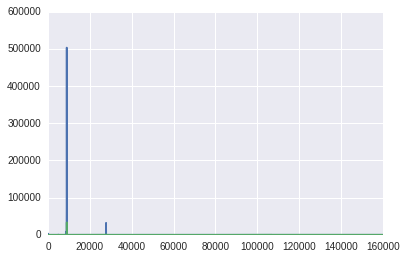

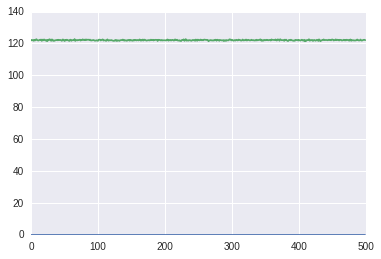

(128, 32, 32, 3)


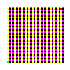

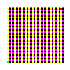

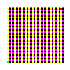

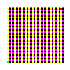

Iter: 162000
D loss: 0.0
G_loss: 121.8
()


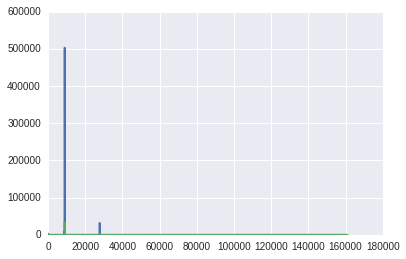

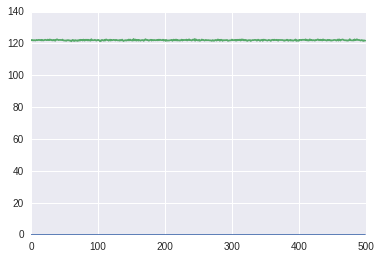

(128, 32, 32, 3)


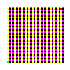

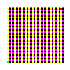

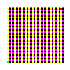

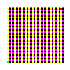

Iter: 163000
D loss: 0.0
G_loss: 122.0
()


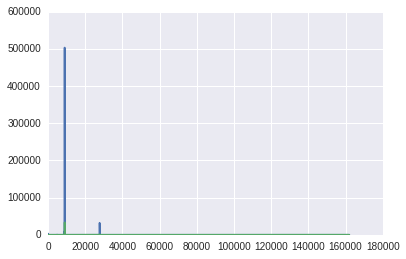

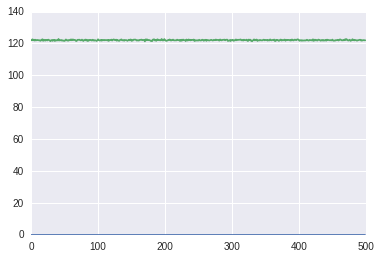

(128, 32, 32, 3)


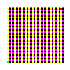

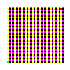

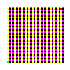

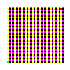

Iter: 164000
D loss: 0.0
G_loss: 121.8
()


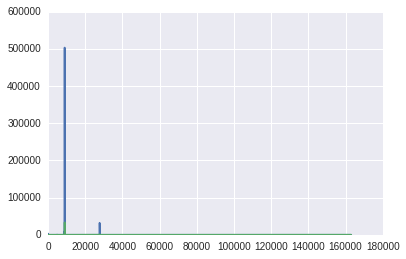

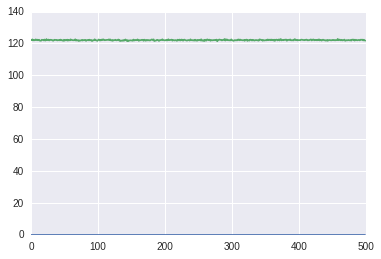

(128, 32, 32, 3)


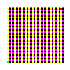

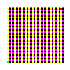

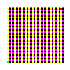

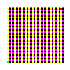

Iter: 165000
D loss: 0.0
G_loss: 122.1
()


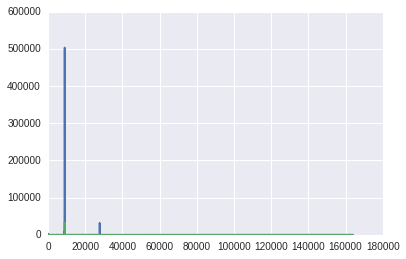

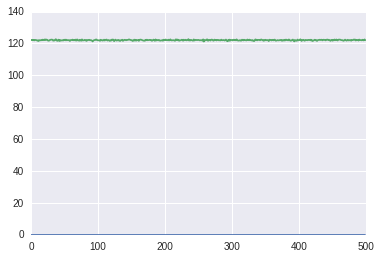

(128, 32, 32, 3)


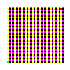

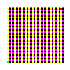

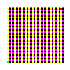

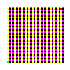

Iter: 166000
D loss: 0.0
G_loss: 122.1
()


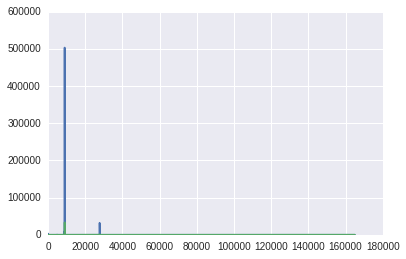

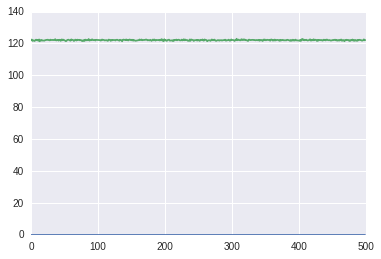

(128, 32, 32, 3)


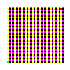

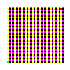

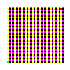

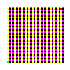

Iter: 167000
D loss: 0.0
G_loss: 122.1
()


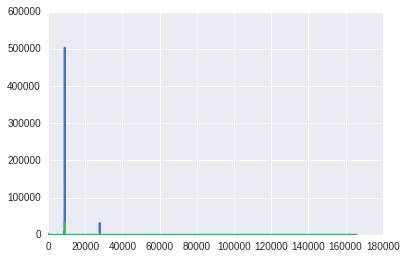

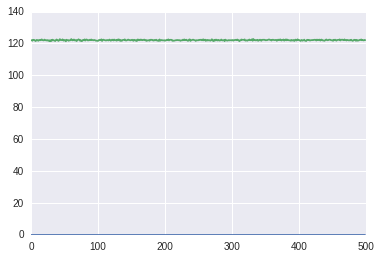

(128, 32, 32, 3)


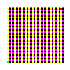

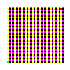

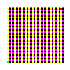

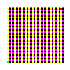

Iter: 168000
D loss: 0.0
G_loss: 122.1
()


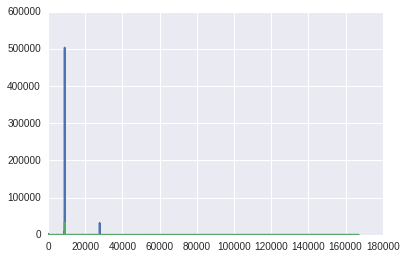

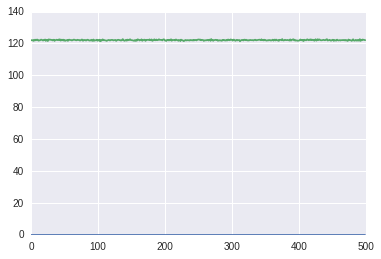

(128, 32, 32, 3)


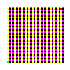

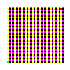

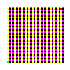

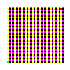

Iter: 169000
D loss: 0.0
G_loss: 121.5
()


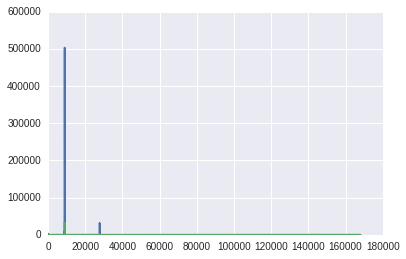

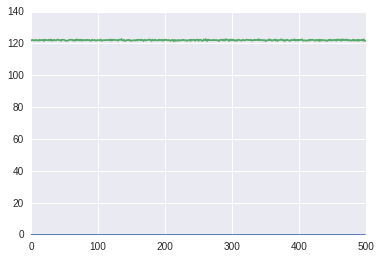

(128, 32, 32, 3)


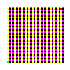

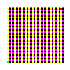

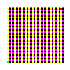

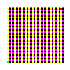

Iter: 170000
D loss: 0.0
G_loss: 122.3
()


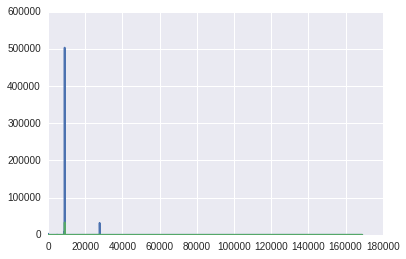

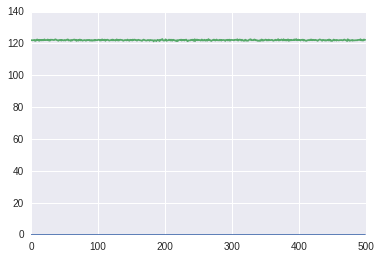

(128, 32, 32, 3)


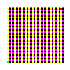

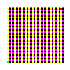

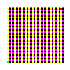

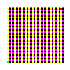

Iter: 171000
D loss: 0.0
G_loss: 122.5
()


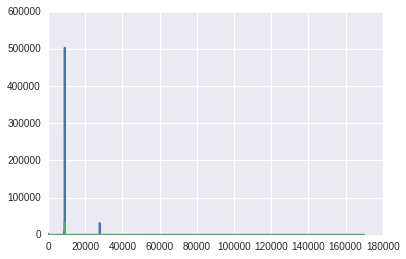

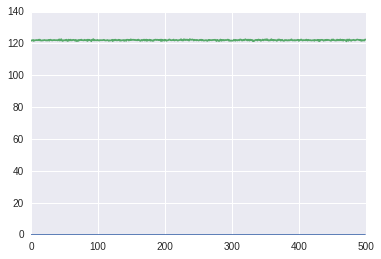

(128, 32, 32, 3)


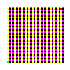

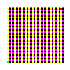

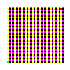

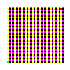

Iter: 172000
D loss: 0.0
G_loss: 122.0
()


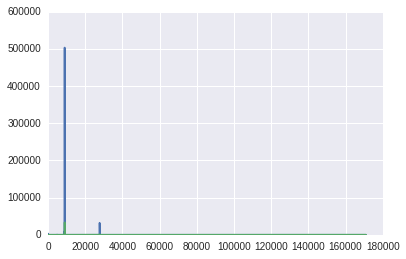

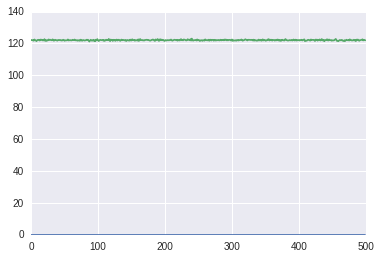

(128, 32, 32, 3)


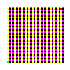

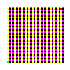

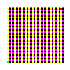

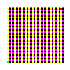

Iter: 173000
D loss: 0.0
G_loss: 121.9
()


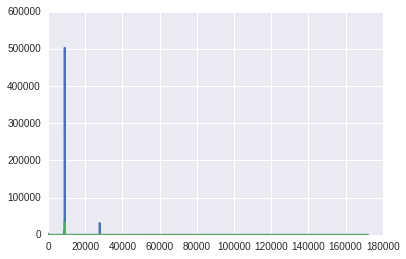

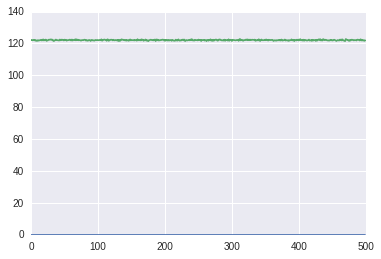

(128, 32, 32, 3)


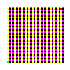

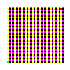

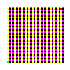

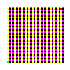

Iter: 174000
D loss: 0.0
G_loss: 122.1
()


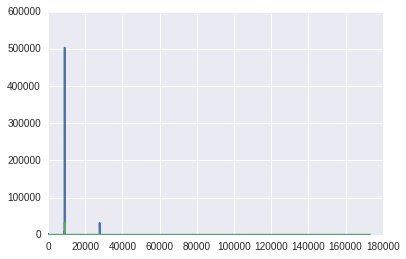

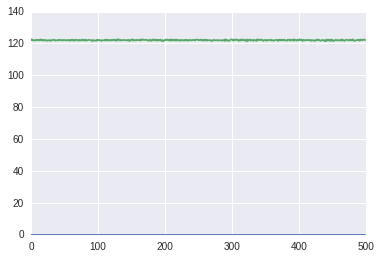

(128, 32, 32, 3)


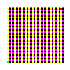

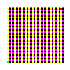

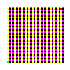

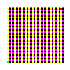

Iter: 175000
D loss: 0.0
G_loss: 122.1
()


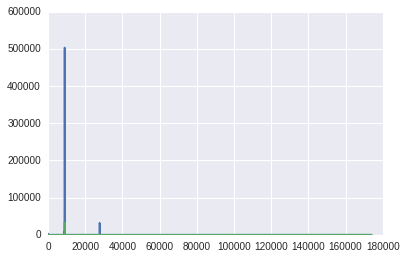

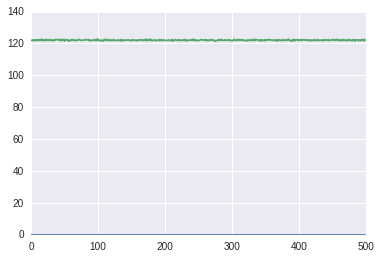

(128, 32, 32, 3)


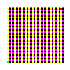

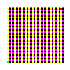

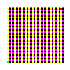

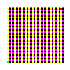

Iter: 176000
D loss: 0.0
G_loss: 122.0
()


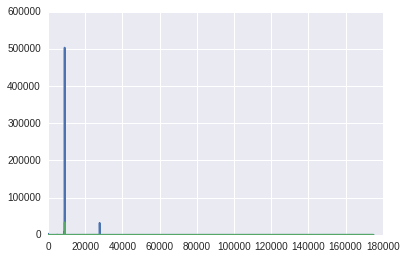

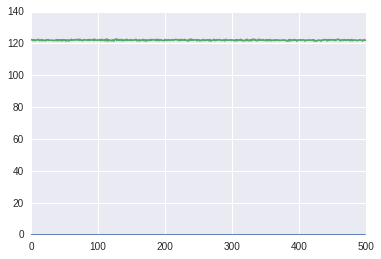

(128, 32, 32, 3)


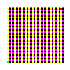

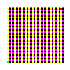

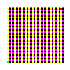

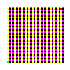

Iter: 177000
D loss: 0.0
G_loss: 121.9
()


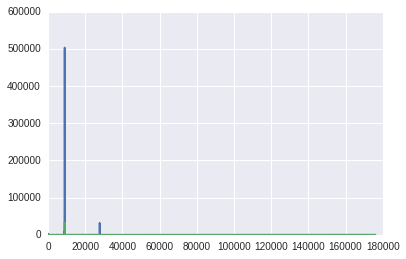

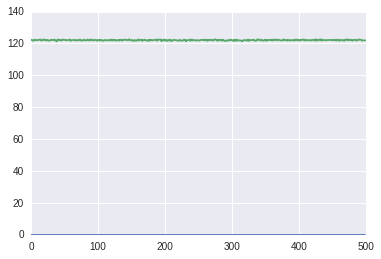

(128, 32, 32, 3)


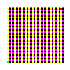

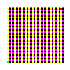

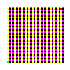

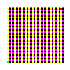

Iter: 178000
D loss: 0.0
G_loss: 122.0
()


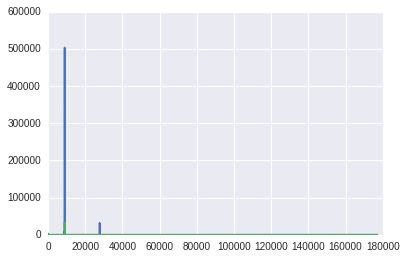

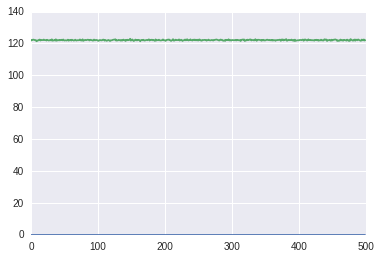

(128, 32, 32, 3)


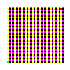

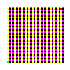

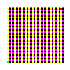

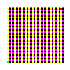

Iter: 179000
D loss: 0.0
G_loss: 122.3
()


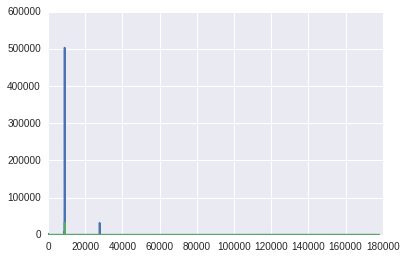

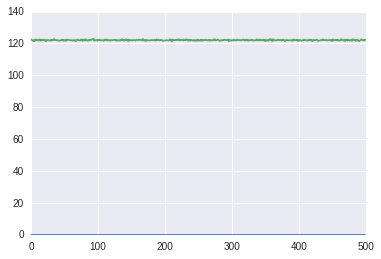

(128, 32, 32, 3)


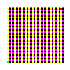

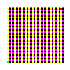

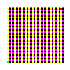

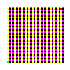

Iter: 180000
D loss: 0.0
G_loss: 121.7
()


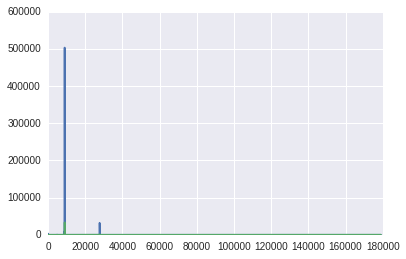

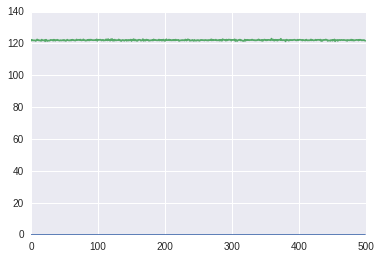

(128, 32, 32, 3)


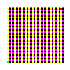

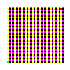

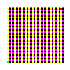

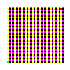

Iter: 181000
D loss: 0.0
G_loss: 122.1
()


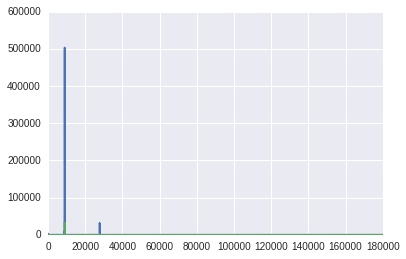

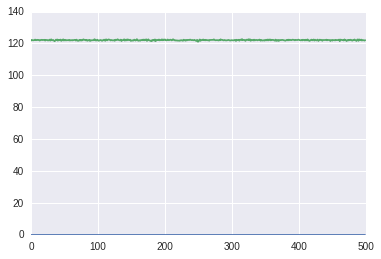

(128, 32, 32, 3)


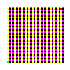

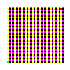

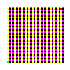

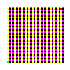

Iter: 182000
D loss: 0.0
G_loss: 122.2
()


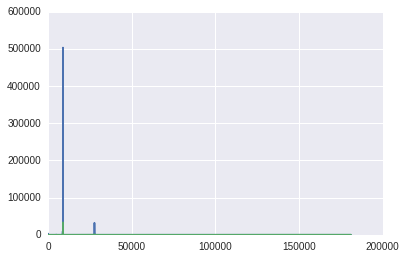

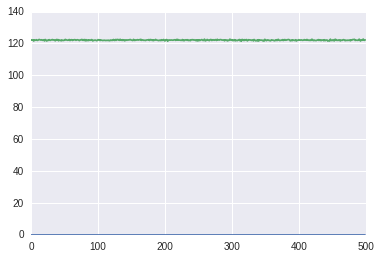

(128, 32, 32, 3)


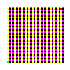

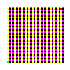

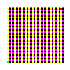

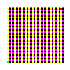

Iter: 183000
D loss: 0.0
G_loss: 122.2
()


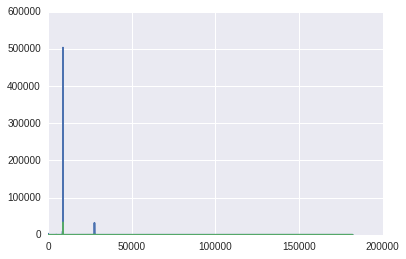

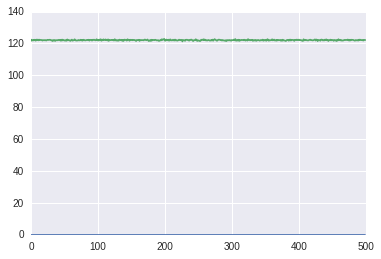

(128, 32, 32, 3)


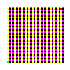

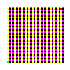

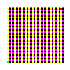

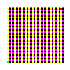

Iter: 184000
D loss: 0.0
G_loss: 122.2
()


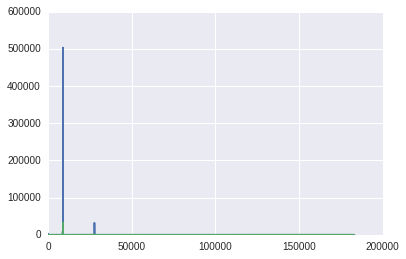

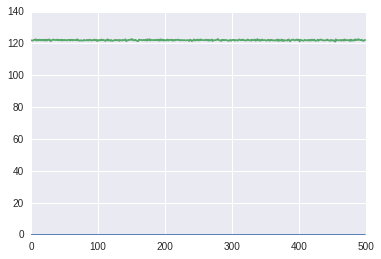

(128, 32, 32, 3)


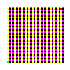

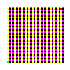

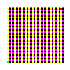

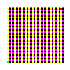

Iter: 185000
D loss: 0.0
G_loss: 121.8
()


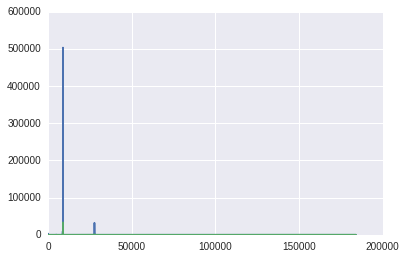

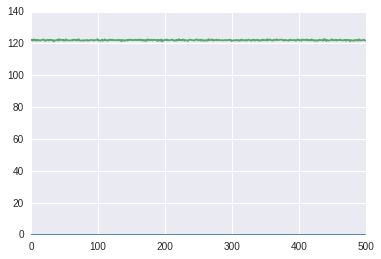

(128, 32, 32, 3)


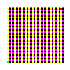

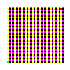

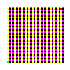

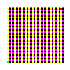

Iter: 186000
D loss: 0.0
G_loss: 122.0
()


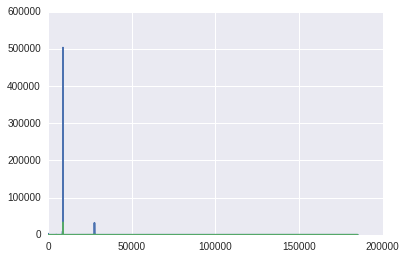

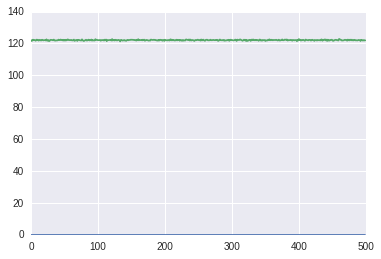

(128, 32, 32, 3)


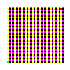

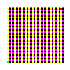

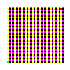

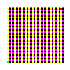

Iter: 187000
D loss: 0.0
G_loss: 122.4
()


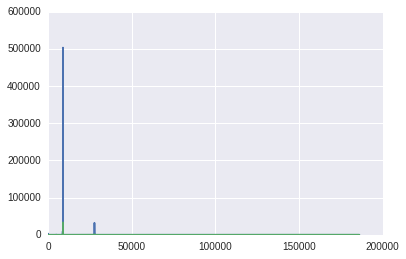

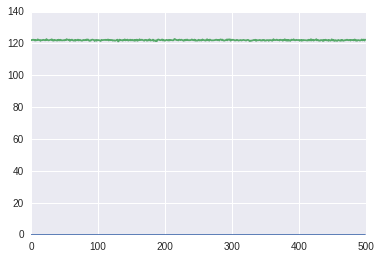

(128, 32, 32, 3)


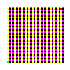

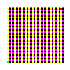

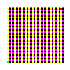

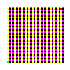

Iter: 188000
D loss: 0.0
G_loss: 122.2
()


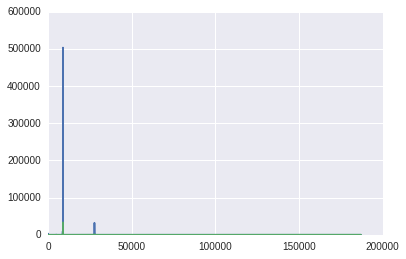

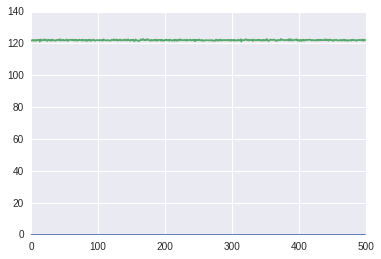

(128, 32, 32, 3)


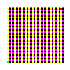

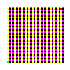

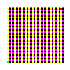

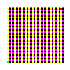

KeyboardInterrupt: 

In [14]:
def get_batch(n):
    idx = np.random.randint(len(X_data_set), size=n).astype(int32)
    return X_data_set[idx], Y_data_set[idx]
# print X, Y

mb_size = 128

for it in range(1000000):


    X_mb, Y_mb = get_batch(mb_size)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_ph: X_mb, Z_ph: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})

    D_loss_record.append(D_loss_curr)
    G_loss_record.append(G_loss_curr)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        plt.plot(D_loss_record[1000:])
        plt.plot(G_loss_record[1000:])
        plt.show()
        
        plt.plot(D_loss_record[-500:])
        plt.plot(G_loss_record[-500:])
        plt.show()
        images_val = sess.run(G_sample, feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})
        print images_val.shape
        for i in range(4):
            show_cifar_image(images_val[i])
        